## File description 

This file is meant to clean and tranform the data already existing to a format that will be used for labelling. More Data cleaning will be done during the EDA, after the labelling.


Some EDA and feature engineering will be done here but as the data is not labelled, most of it will be done after the labelling.

## 0. Modules and UDFs

In [1]:
import src.viz as sv
import src.useful as su

import sqlite3
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from datetime import datetime, timedelta
import demoji
from coolname import generate_slug
from urllib.parse import urlparse

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff

from tqdm import tqdm

import os
import shutil

from IPython.display import Image

import time
from pandarallel import pandarallel

### 0.1 Setting notebook preferences
Setting pandas to not limit the number of displayed columns and connect to the database.

In [2]:
pd.set_option("display.max_columns", None)
pio.templates.default = "plotly_dark"

# Creating SQL database to store all the data for the project
database = "data/main_database.sqlite"
con = sqlite3.connect(database)

start = time.time()
pandarallel.initialize(verbose=0)

In [3]:
# # Print all the tables in the database with their size
# query = '''
# select 
#     * 
# from sqlite_master'''

# df_sqlite_master = pd.read_sql_query('select * from sqlite_master', con)
# for tbl in df_sqlite_master['tbl_name']:
#     if 'clean' not in tbl: 
#         print(tbl, pd.read_sql_query(f'select * from {tbl}', con).shape)

Now, each table is going to be cleaned and put in a nice format ready to be used during the data labelling

### 0.2 Changing all usernames names for cooler names

This is to be done on all dataset so better doing it at the beginning

In [4]:
# Loading all dfs and creating a list of it
df_comments = pd.read_sql_query('select distinct * from comments', con)
df_users = pd.read_sql_query('select distinct * from profiles', con)
df_last12 = pd.read_sql_query('select distinct * from last12', con)
all_dfs = [df_comments, df_users, df_last12]

# List all usernames
all_usernames = [username for df in all_dfs for username in df['username']]
print(len(all_usernames))
all_usernames = set(all_usernames)
print(len(all_usernames))

632521
88624


In [5]:
for df in all_dfs: 
    print(df.shape)

(134465, 12)
(94848, 97)
(403208, 9)


Creating new name dictionary and save it direclty

In [6]:
# Get a cool name for each of them, run only once
# cooler_name = {username: generate_slug(3) for index, username in enumerate(all_usernames)}
# df_username_mapping = pd.DataFrame([[i, j] for i, j in cooler_name.items()], columns=['username', 'cooler_name'])
# df_username_mapping.to_sql('username_mapping', con, if_exists='fail', index=False)

In [7]:
# Get a cool name for each of them
df_username_mapping = pd.read_sql_query('select * from username_mapping', con)
cooler_names = dict(df_username_mapping.values)

df_comments['username'] = df_comments['username'].map(cooler_names)
df_users['username'] = df_users['username'].map(cooler_names)
df_last12['username'] = df_last12['username'].map(cooler_names)

# # for index, df in enumerate(all_dfs):
# #     df['cool_username'] = [cooler_names[username] for username in df['username']]

# #     # Flipping the columns so that username is replaced last
# #     for column in df.iloc[:, ::-1].columns: 
# #         if df[column].dtype == 'object':
# #             try:
# #                 df[column] = df.apply(lambda x: x[column].replace(x['username'], x['cool_username']) if type(x[column]) == str else x['username'], axis=1)
# #             except Exception as e: 
# #                 print(f'{[name for name in globals() if globals()[name] is all_dfs[index]][0]}, {column} - {e}')
    
# #     # all_dfs[index] = df 
# #     sub_df = df.copy()




# df_last12['username']

In [8]:
os.system('say "error"')
# asdfadsfs

0

## 1. Comments

This table contains all the comments collected and each row of the table represent a single comment. It's possible that if a user commented twice on a post, I collected both of the comment or caught the comment of the same users on multiple post.
The goal is to clean the table, and output it in a clean and organized table containing one comment per row.

### 1.1 Load data and quick explore

In [9]:
df_comments.head()

page       postid  \
0  bleacherreport  CYsUBv7KPFR   
1  bleacherreport  CYsUBv7KPFR   
2  bleacherreport  CYsUBv7KPFR   
3  bleacherreport  CYsUBv7KPFR   
4  bleacherreport  CYsUBv7KPFR   

                                              legend     post_likes  \
0  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   
1  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   
2  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   
3  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   
4  bleacherreportVerifiedThis Bobby Portis celebr...  306,460 likes   

           post_posted_time                       username  \
0  2022-01-14T01:41:02.000Z  carrot-mastodon-of-enthusiasm   
1  2022-01-14T01:41:02.000Z       new-statuesque-binturong   
2  2022-01-14T01:41:02.000Z           adorable-jade-beluga   
3  2022-01-14T01:41:02.000Z      hysterical-glistening-bee   
4  2022-01-14T01:41:02.000Z     uber-dragon-of-advertising   

                                   full_comment_data  \
0  takeajaytripBRUH THE BUCKS CANT MISS A SHOT3d2...   
1  reymarkable_pBobby Portis shooting > Steph sho...   
2  jimmy_jaime94Bucks finna have a repeat 🏆 👀3d96...   
3  4thgearcrewCRAZY EYES GOT MOVES LOL 🤣🤣😭3d1,024...   
4  __.jayriggzCan’t wait for flights reaction 😂😂3...   

                                  comment       comment_posted_time  \
0         BRUH THE BUCKS CANT MISS A SHOT  2022-01-14T01:41:33.000Z   
1  Bobby Portis shooting > Steph shooting  2022-01-14T01:42:49.000Z   
2           Bucks finna have a repeat 🏆 👀  2022-01-14T01:42:37.000Z   
3            CRAZY EYES GOT MOVES LOL 🤣🤣😭  2022-01-14T01:45:12.000Z   
4      Can’t wait for flights reaction 😂😂  2022-01-14T01:45:27.000Z   

  comments_likes  comment_comments_count         data_collected_time  
0    2,234 likes                       8  2022-01-17 02:18:25.197544  
1    3,011 likes                      24  2022-01-17 02:18:25.199751  
2      967 likes                      43  2022-01-17 02:18:25.200984  
3    1,024 likes                       7  2022-01-17 02:18:25.202163  
4      966 likes                       5  2022-01-17 02:18:25.203335

In [10]:
df_comments.describe(include='all').round()

page       postid  \
count   134465       134465   
unique      24         5614   
top        nfl  CYh6UW-IWUc   
freq      9544           80   
mean       NaN          NaN   
std        NaN          NaN   
min        NaN          NaN   
25%        NaN          NaN   
50%        NaN          NaN   
75%        NaN          NaN   
max        NaN          NaN   

                                                   legend     post_likes  \
count                                              134465         134465   
unique                                               5593           5579   
top     slamVerifiedThis is a shout out to one of our ...  231,598 likes   
freq                                                   80            120   
mean                                                  NaN            NaN   
std                                                   NaN            NaN   
min                                                   NaN            NaN   
25%                                                   NaN            NaN   
50%                                                   NaN            NaN   
75%                                                   NaN            NaN   
max                                                   NaN            NaN   

                post_posted_time                 username   full_comment_data  \
count                     134465                   134465              134465   
unique                      5605                    88594              133776   
top     2022-01-10T00:44:01.000Z  rational-elk-of-respect  chris_lio7🔥7wReply   
freq                         104                      316                   7   
mean                         NaN                      NaN                 NaN   
std                          NaN                      NaN                 NaN   
min                          NaN                      NaN                 NaN   
25%                          NaN                      NaN                 NaN   
50%                          NaN                      NaN                 NaN   
75%                          NaN                      NaN                 NaN   
max                          NaN                      NaN                 NaN   

       comment       comment_posted_time comments_likes  \
count   134465                    134465         134465   
unique  119362                    124263           7610   
top        🔥🔥🔥  2022-01-02T18:24:58.000Z          Reply   
freq       234                        10          16003   
mean       NaN                       NaN            NaN   
std        NaN                       NaN            NaN   
min        NaN                       NaN            NaN   
25%        NaN                       NaN            NaN   
50%        NaN                       NaN            NaN   
75%        NaN                       NaN            NaN   
max        NaN                       NaN            NaN   

        comment_comments_count         data_collected_time  
count               134,465.00                      134465  
unique                     NaN                      134465  
top                        NaN  2022-01-17 02:18:25.197544  
freq                       NaN                           1  
mean                      7.00                         NaN  
std                      22.00                         NaN  
min                       0.00                         NaN  
25%                       0.00                         NaN  
50%                       1.00                         NaN  
75%                       7.00                         NaN  
max                   2,543.00                         NaN

In [11]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134465 entries, 0 to 134464
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   page                    134465 non-null  object
 1   postid                  134465 non-null  object
 2   legend                  134465 non-null  object
 3   post_likes              134465 non-null  object
 4   post_posted_time        134465 non-null  object
 5   username                134465 non-null  object
 6   full_comment_data       134465 non-null  object
 7   comment                 134465 non-null  object
 8   comment_posted_time     134465 non-null  object
 9   comments_likes          134465 non-null  object
 10  comment_comments_count  134465 non-null  int64 
 11  data_collected_time     134465 non-null  object
dtypes: int64(1), object(11)
memory usage: 12.3+ MB


Luckily no duplicates, some columns as likes and comment likes need to be integers, others as the dates need to me in a date format.

* There are 134.465 rows of data, meaning the same number of comments
* Total of 88608 users meaning an average of 1.5 comment per user
* Post likes and comment need the numbers to be extracted and columns changed to integer 
* The three date columns don't have a correct type
* Some columns names are not explicit enough, might need to change them
* Some columns are irrelevant to this analysis. For example, the legend of the post will have no effect on the bot/non bot user so there is no point of keeping them
* No missing values! :emoji_dab:

### 1.2 Removing irrelevant columns & column names

I collected too much data, some columns are irrelevant to the analysis or the model develoment as the page, postid, post_likes and others are independant from the bots.

In [12]:
df_comments.drop_duplicates().shape[0], df_comments.shape[0]

(134465, 134465)

In [13]:
df_comments = df_comments.rename({'legend': 'caption',
                                  'comment_comments_count': 'comment_reply_count',
                                  'comments_likes': 'comment_likes'}, axis=1)

# Removing irrelevant columns and changing the columns order
df_comments = df_comments[["username", "comment", "comment_likes", "comment_posted_time", "post_posted_time"]].drop_duplicates()

df_comments.head(0)

Empty DataFrame
Columns: [username, comment, comment_likes, comment_posted_time, post_posted_time]
Index: []

### 1.4 Posted time

Both posted time columns don't have the proper datatype, they need to be datetime. Itself they don't help much but I can subtract both date and know how many seconds after the post has been posted, the comment has been too. 

the column comment posted time is very important as many users spam the same commment and have 0-0 likes accros the tries, keeping the columns comment posted time prevent from removing fake duplicated.

In [14]:
# Changing columns to datetime type
df_comments["post_posted_time"] = pd.to_datetime(df_comments["post_posted_time"])
df_comments["comment_posted_time"] = pd.to_datetime(df_comments["comment_posted_time"])

# Getting time diff and removing posted time columns
df_comments["comment_time_difference"] = (df_comments["comment_posted_time"] - df_comments["post_posted_time"]).dt.seconds
df_comments = df_comments.drop(["post_posted_time"], axis=1)

df_comments.head()

username                                 comment  \
0  carrot-mastodon-of-enthusiasm         BRUH THE BUCKS CANT MISS A SHOT   
1       new-statuesque-binturong  Bobby Portis shooting > Steph shooting   
2           adorable-jade-beluga           Bucks finna have a repeat 🏆 👀   
3      hysterical-glistening-bee            CRAZY EYES GOT MOVES LOL 🤣🤣😭   
4     uber-dragon-of-advertising      Can’t wait for flights reaction 😂😂   

  comment_likes       comment_posted_time  comment_time_difference  
0   2,234 likes 2022-01-14 01:41:33+00:00                       31  
1   3,011 likes 2022-01-14 01:42:49+00:00                      107  
2     967 likes 2022-01-14 01:42:37+00:00                       95  
3   1,024 likes 2022-01-14 01:45:12+00:00                      250  
4     966 likes 2022-01-14 01:45:27+00:00                      265

In [15]:
df_comments['comment_time_difference'].describe().astype(int).to_frame()

comment_time_difference
count                   134226
mean                      3290
std                      11380
min                          3
25%                         70
50%                        194
75%                        596
max                      86394

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/distribution_of_the_time_diff_between_the_post_and_comment.html


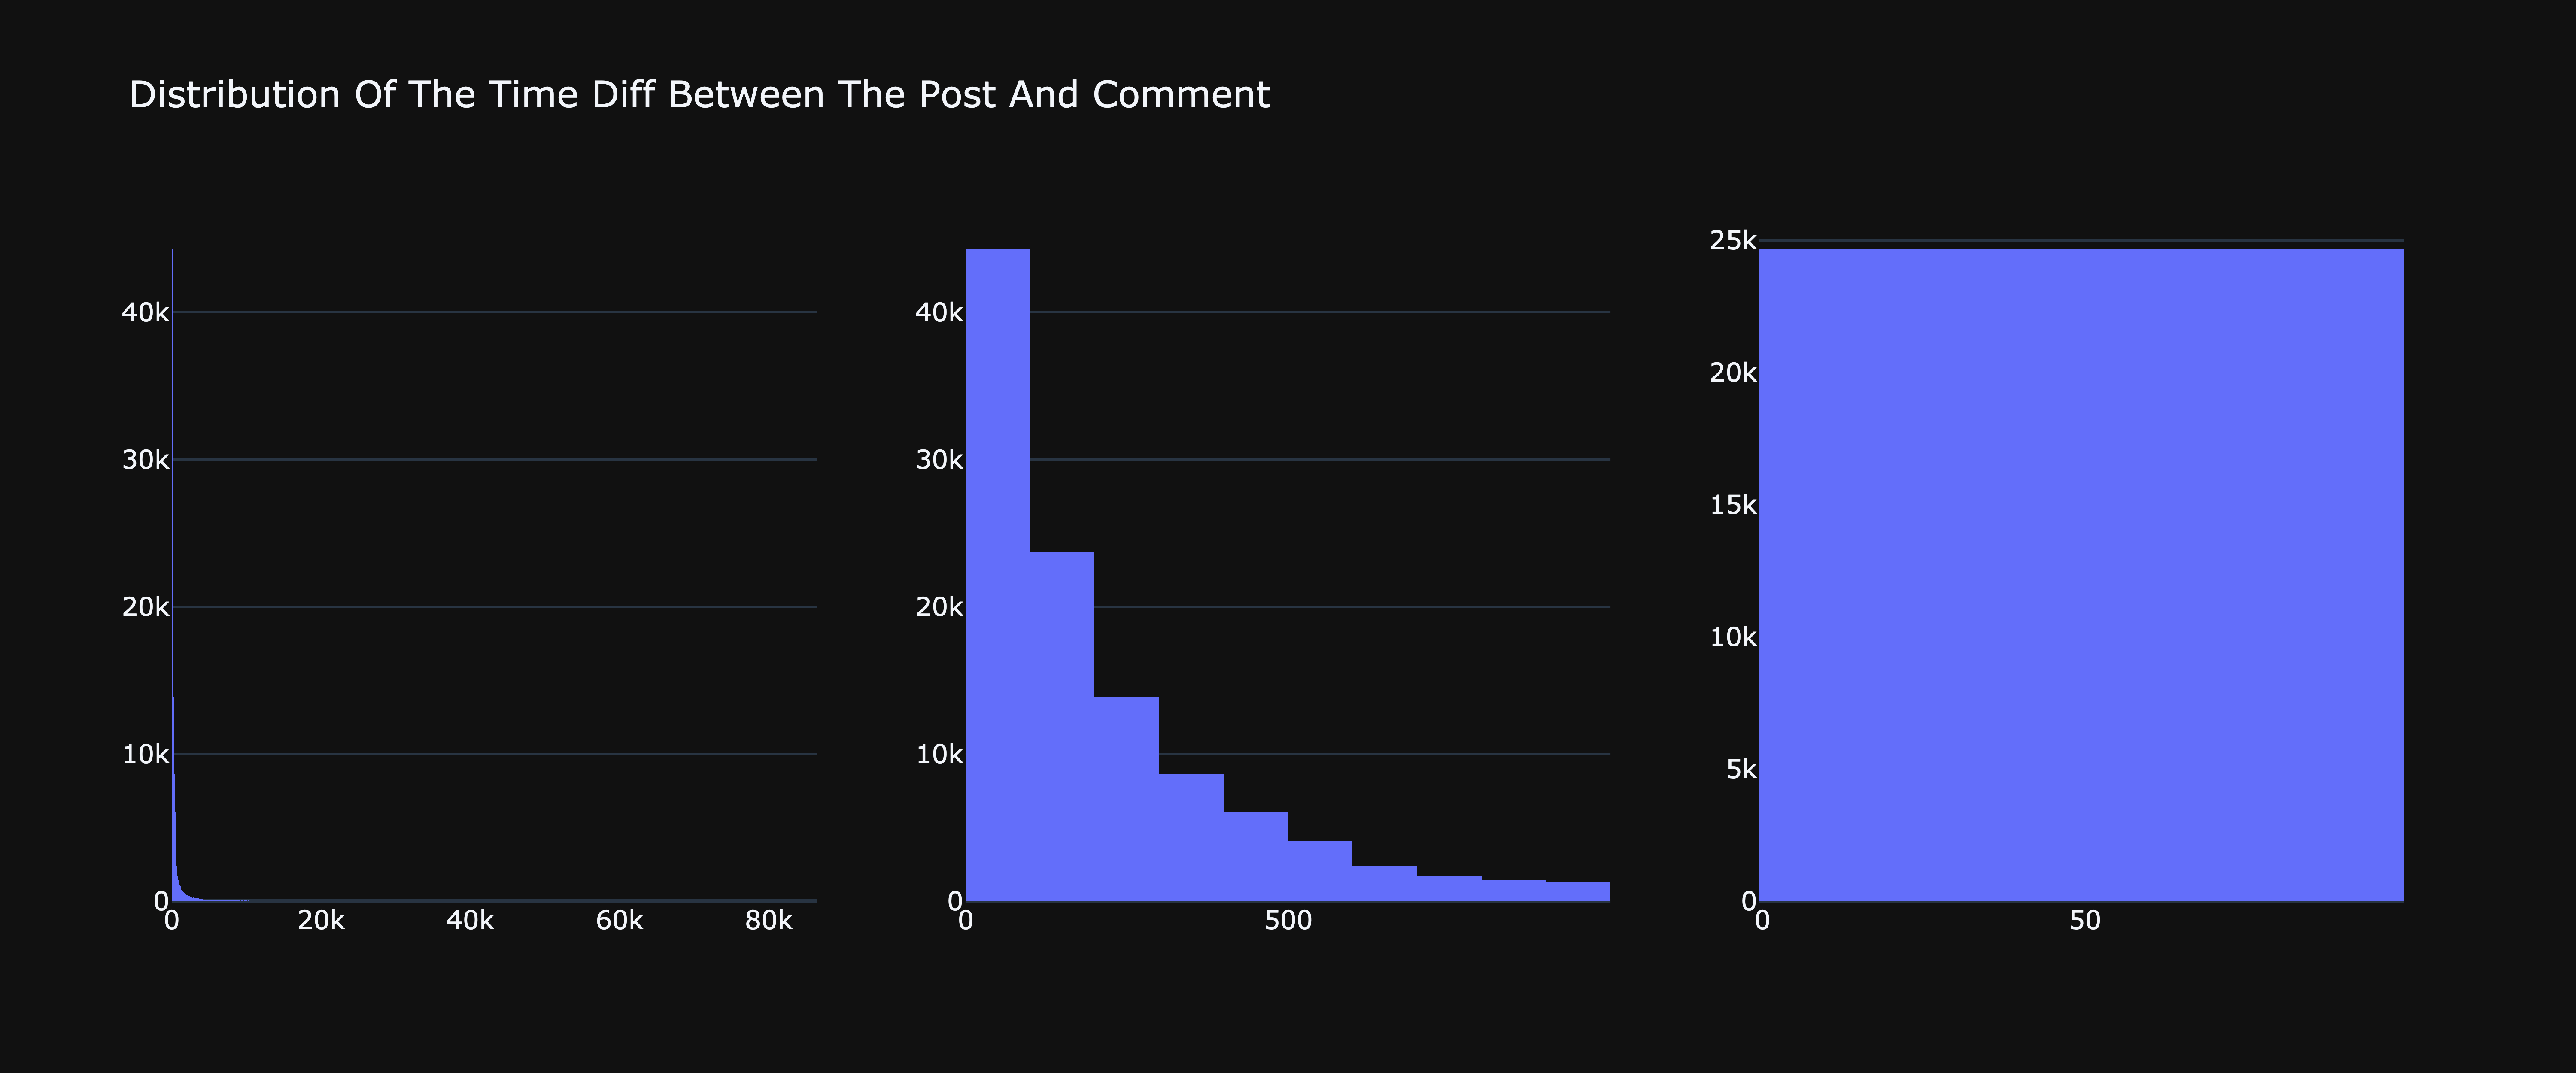

In [16]:
# Show distribution of the comments and the time difference
fig1 = px.histogram(df_comments, 
                    x = 'comment_time_difference')
                    
fig2 = px.histogram(df_comments.query('comment_time_difference < 1000'), 
                    x = 'comment_time_difference', 
                    nbins = 1000)

fig3 = px.histogram(df_comments.query('comment_time_difference < 50'), 
                    x = 'comment_time_difference',
                    nbins=50)


# Join figures
fig_join = sv.join_plots([fig1, fig2, fig3],
                         title='Distribution of the time diff between the post and comment',
                         subtitle='Charts 2 & 3 are filtered on time diff < 1000 and < 50')

# Save chart
file_name = 'Distribution of the time diff between the post and comment - Dual Histogram lt 1000'
sv.save_plotly_fig(fig_join, 'image')

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/distribution_of_the_time_diff_between_the_post_and_comment.html


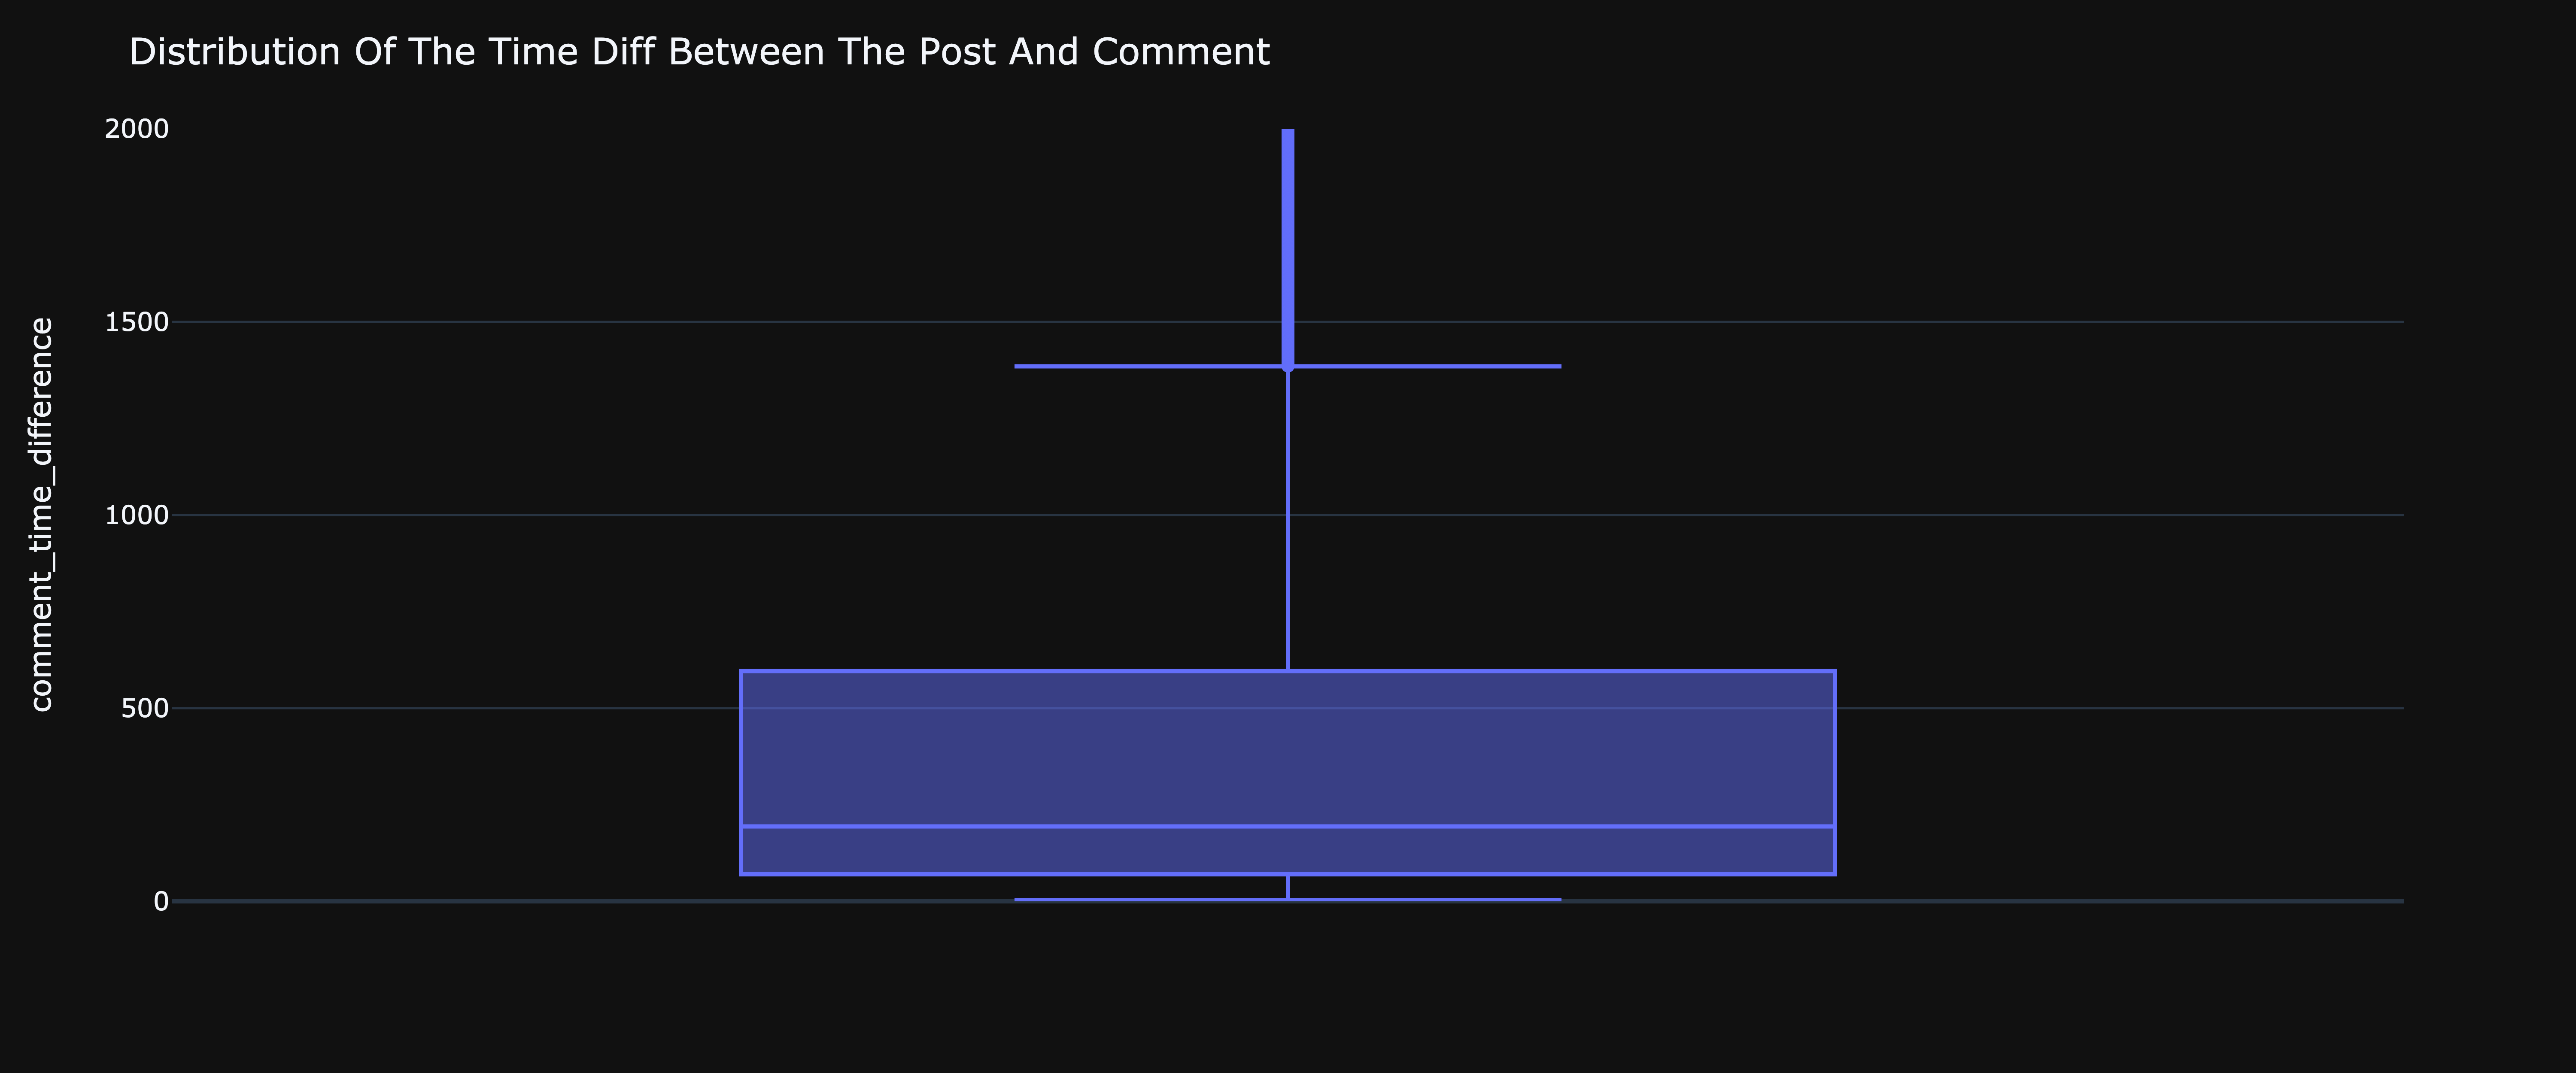

In [17]:
# Create box plot 
fig = px.box(df_comments, y="comment_time_difference")
fig.update_layout(yaxis_range=(0, 2000), # Don't show the chart above 1000 seconds
                  title='Distribution of the time diff between the post and comment<br><sub>Outliers starting at ~1500 in time_diff, showing range stops at 2.000.')


# Save chart
file_name = 'Distribution of the time diff between the post and comment - Dual Histogram lt 500'
sv.save_plotly_fig(fig, 'image')

For most of the comments collected, 75% have been posted in the first 10 minutes after the post has been posted. The median is a third of that, half of the comments were posted in the first three minutes. The peak of the most comments posted at the same time happends 19-20 seconds after the post is published. Once the users are labelled, it'll be interesting to see the difference in that 0-20 seconds window to see the ratio of bots compared to later. The data is not representative of all Instagram data as when collecting it, I was starting collecting the first IG was showing, the ones with the most likes.

### 1.5 Comment
The like columns is string containing the number of likes formated with thousand commas followed by 'Likes'. The column should be and ineger without any character being non numeric

In [18]:
df_comments

username  \
0            carrot-mastodon-of-enthusiasm   
1                 new-statuesque-binturong   
2                     adorable-jade-beluga   
3                hysterical-glistening-bee   
4               uber-dragon-of-advertising   
...                                    ...   
134460                unique-gaur-of-karma   
134461                 prudent-rare-dragon   
134462            grinning-rugged-parakeet   
134463                imported-famous-tody   
134464  important-partridge-of-performance   

                                                  comment comment_likes  \
0                         BRUH THE BUCKS CANT MISS A SHOT   2,234 likes   
1                  Bobby Portis shooting > Steph shooting   3,011 likes   
2                           Bucks finna have a repeat 🏆 👀     967 likes   
3                            CRAZY EYES GOT MOVES LOL 🤣🤣😭   1,024 likes   
4                      Can’t wait for flights reaction 😂😂     966 likes   
...                                                   ...           ...   
134460  They’re not bothering anyone. They’re home. Sa...     258 likes   
134461   Mortal combat is the hoods favorite game not gta     338 likes   
134462       Women be so jealous of our gaming consoles 😂     432 likes   
134463  But if a Nigga wasn’t home and out cheating th...     304 likes   
134464                                      😂😂😂who won 😂😂     218 likes   

             comment_posted_time  comment_time_difference  
0      2022-01-14 01:41:33+00:00                       31  
1      2022-01-14 01:42:49+00:00                      107  
2      2022-01-14 01:42:37+00:00                       95  
3      2022-01-14 01:45:12+00:00                      250  
4      2022-01-14 01:45:27+00:00                      265  
...                          ...                      ...  
134460 2022-01-08 01:31:59+00:00                     1776  
134461 2022-01-08 01:07:36+00:00                      313  
134462 2022-01-08 01:10:54+00:00                      511  
134463 2022-01-08 01:09:28+00:00                      425  
134464 2022-01-08 01:08:49+00:00                      386  

[134226 rows x 5 columns]

In [19]:
print('With likes')
display(df_comments['comment_likes'].head())
print('Without likes')
df_comments.query('comment_likes.str.contains("like")==False')['comment_likes'].head()

With likes


0    2,234 likes
1    3,011 likes
2      967 likes
3    1,024 likes
4      966 likes
Name: comment_likes, dtype: object

Without likes


23     Reply
104    Reply
107    Reply
176    Reply
178    Reply
Name: comment_likes, dtype: object

In [20]:
# Replacing 'Reply' by '0' and then extracting all numbers from the strings
df_comments.loc[df_comments['comment_likes']=='Reply', 'comment_likes'] = '0'
df_comments['comment_likes'] = df_comments['comment_likes'].str.replace('\D+', '', regex=True).astype(int)
df_comments.head()

username                                 comment  \
0  carrot-mastodon-of-enthusiasm         BRUH THE BUCKS CANT MISS A SHOT   
1       new-statuesque-binturong  Bobby Portis shooting > Steph shooting   
2           adorable-jade-beluga           Bucks finna have a repeat 🏆 👀   
3      hysterical-glistening-bee            CRAZY EYES GOT MOVES LOL 🤣🤣😭   
4     uber-dragon-of-advertising      Can’t wait for flights reaction 😂😂   

   comment_likes       comment_posted_time  comment_time_difference  
0           2234 2022-01-14 01:41:33+00:00                       31  
1           3011 2022-01-14 01:42:49+00:00                      107  
2            967 2022-01-14 01:42:37+00:00                       95  
3           1024 2022-01-14 01:45:12+00:00                      250  
4            966 2022-01-14 01:45:27+00:00                      265

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/distribution_of_the_likes_per_comment.html


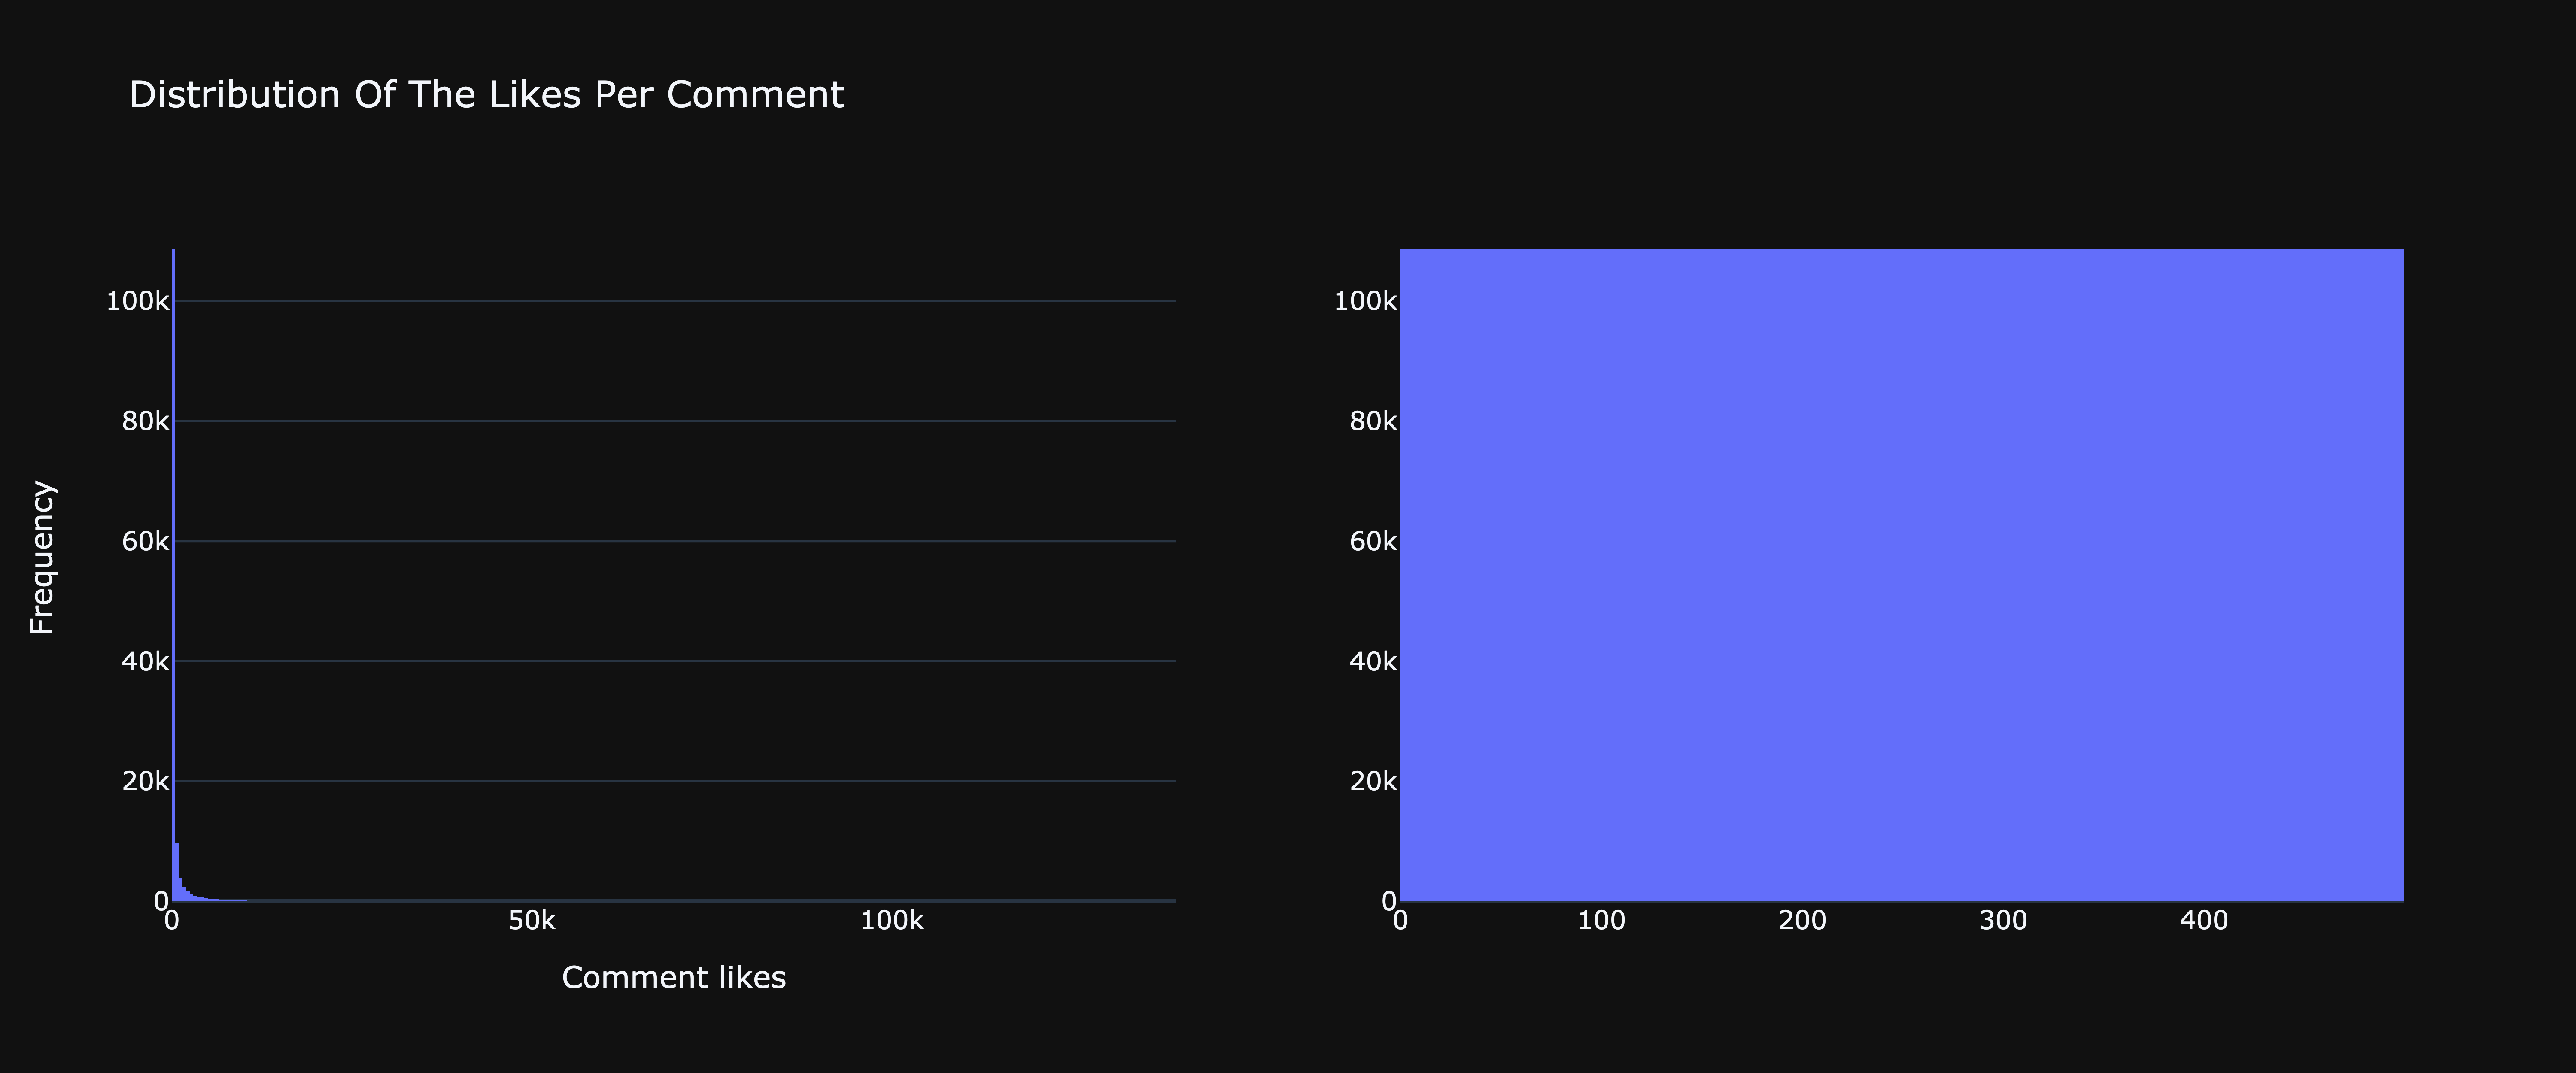

In [21]:
# Show distribution of the comments and the time difference
fig1 = px.histogram(df_comments, 
                    x = 'comment_likes')
                    
fig2 = px.histogram(df_comments.query('comment_likes < 500'), 
                    x = 'comment_likes', 
                    nbins = 400)


fig_join = sv.join_plots([fig1, fig2],
                         title='Distribution of the likes per comment',
                         subtitle='Right chart is filtered on less than 500 likes')

# Update axis names
fig_join.update_layout(xaxis_title="Comment likes",
                       yaxis_title="Frequency")

# Save chart
file_name = 'Distribution of the likes per comment - Dual Histogram lt 500'
sv.save_plotly_fig(fig_join, 'image')

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/distribution_of_the_likes_per_comments.html


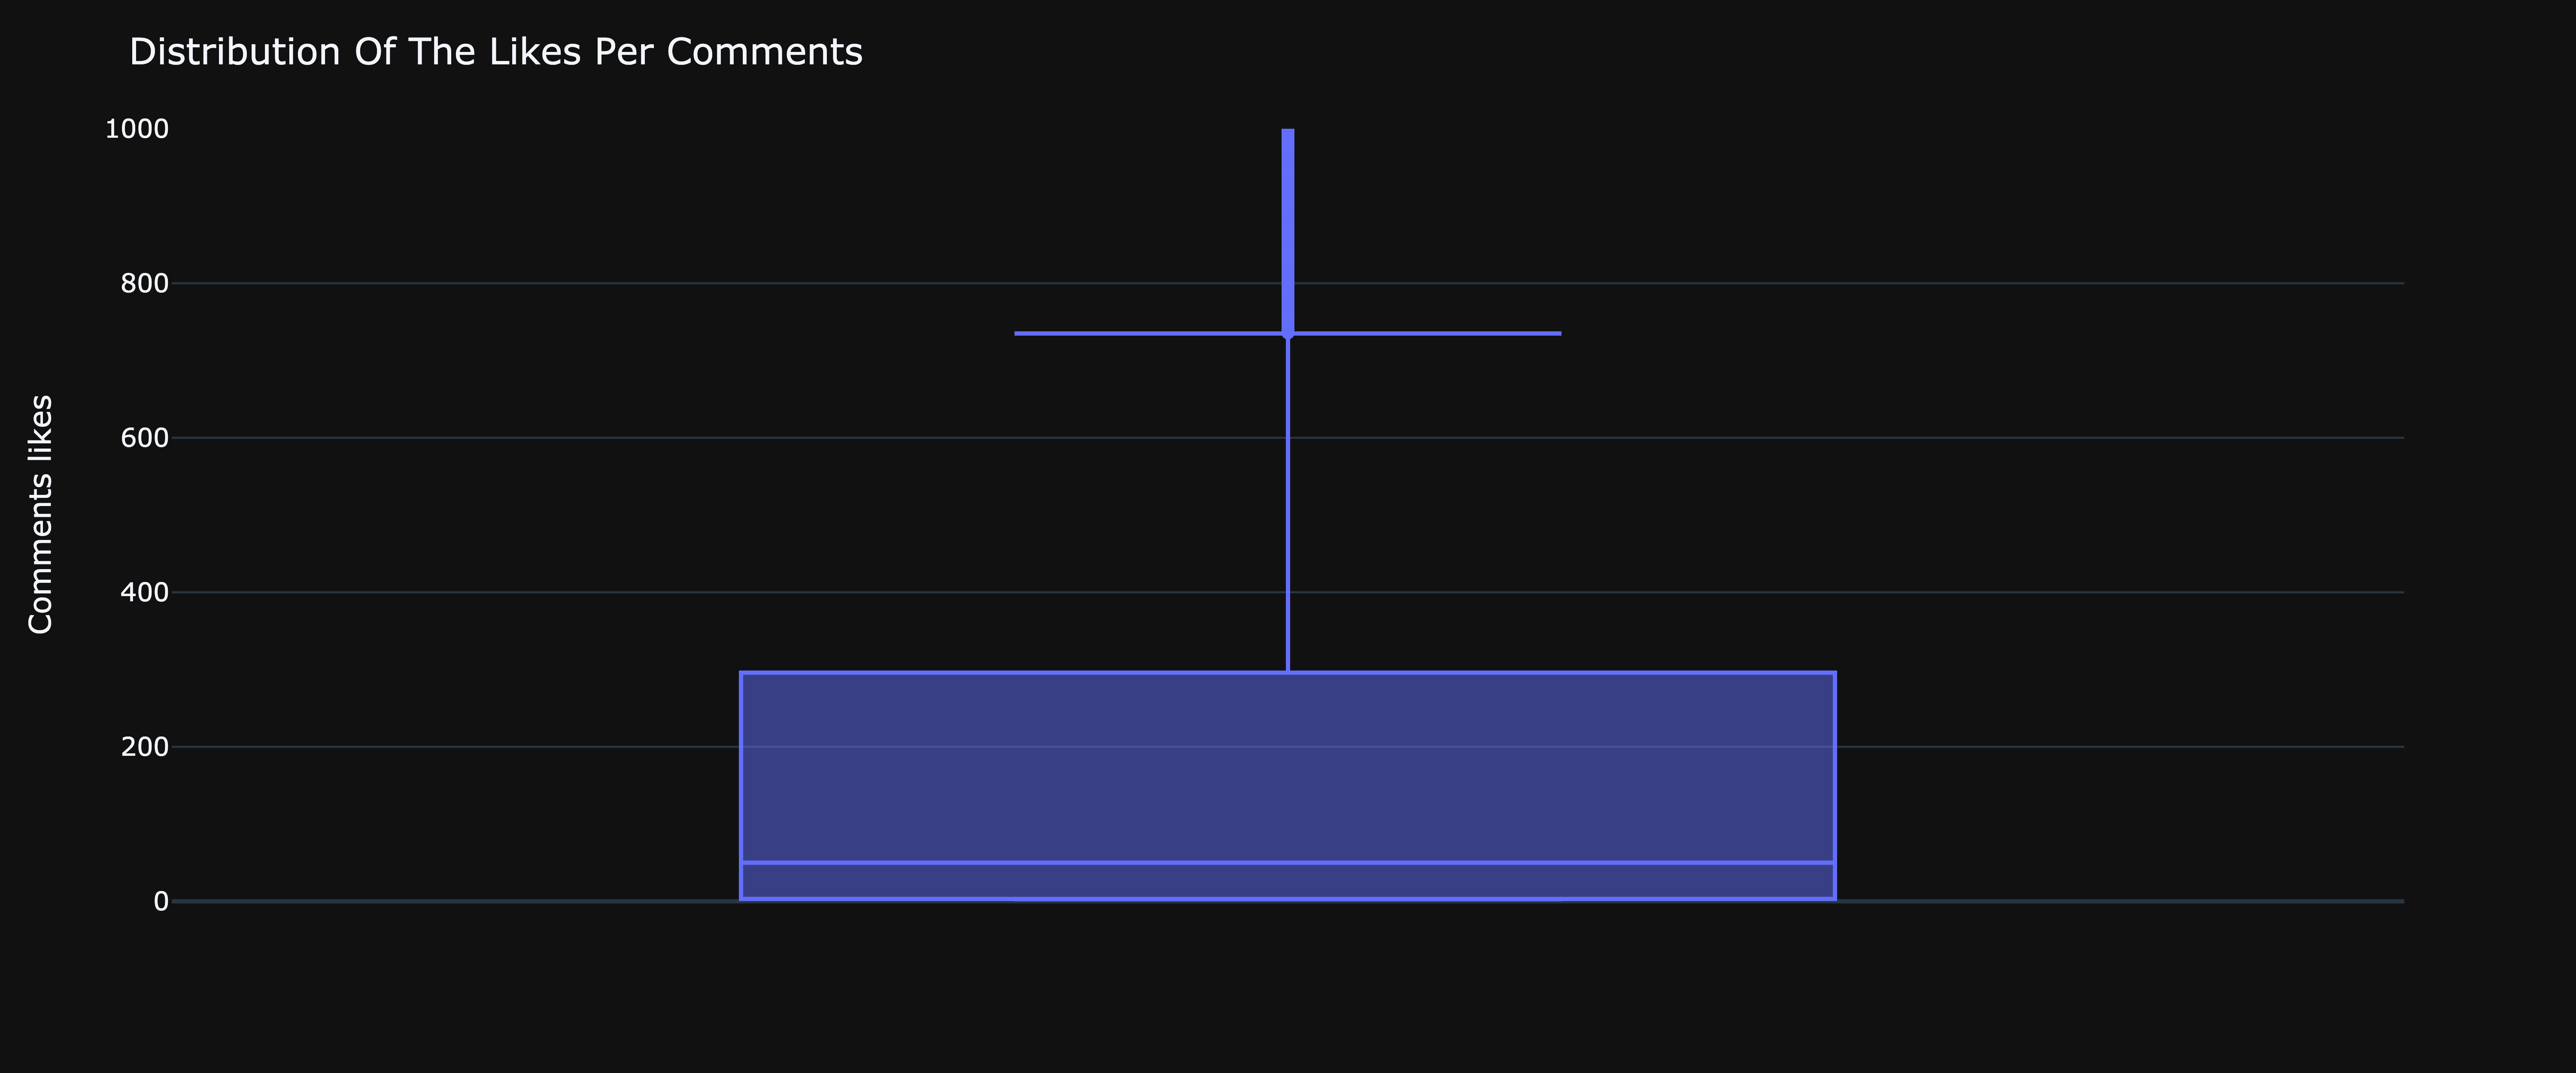

In [22]:
# Create box plot 
fig = px.box(df_comments, 
             y="comment_likes")

fig.update_layout(title='Distribution of the likes per comments', 
                  yaxis_range=(0, 1000), # Don't show the chart above 1000 seconds
                  yaxis_title="Comments likes") 


# Save chart
file_name = 'Distribution of the likes per comment - box plot'
sv.save_plotly_fig(fig, 'image')

75% of the comments have less than 295 likes with half less than 50 likes. Let's look at the relationship with likes and how it varies depending on when the comment has been posted. 

Link for interactability (plotly chart): https://htmlpreview.github.io/?https://github.com/marclelamy/viz/blob/main/instabot/distribution_of_the_comments_per_time_difference_and_comment_likes.html


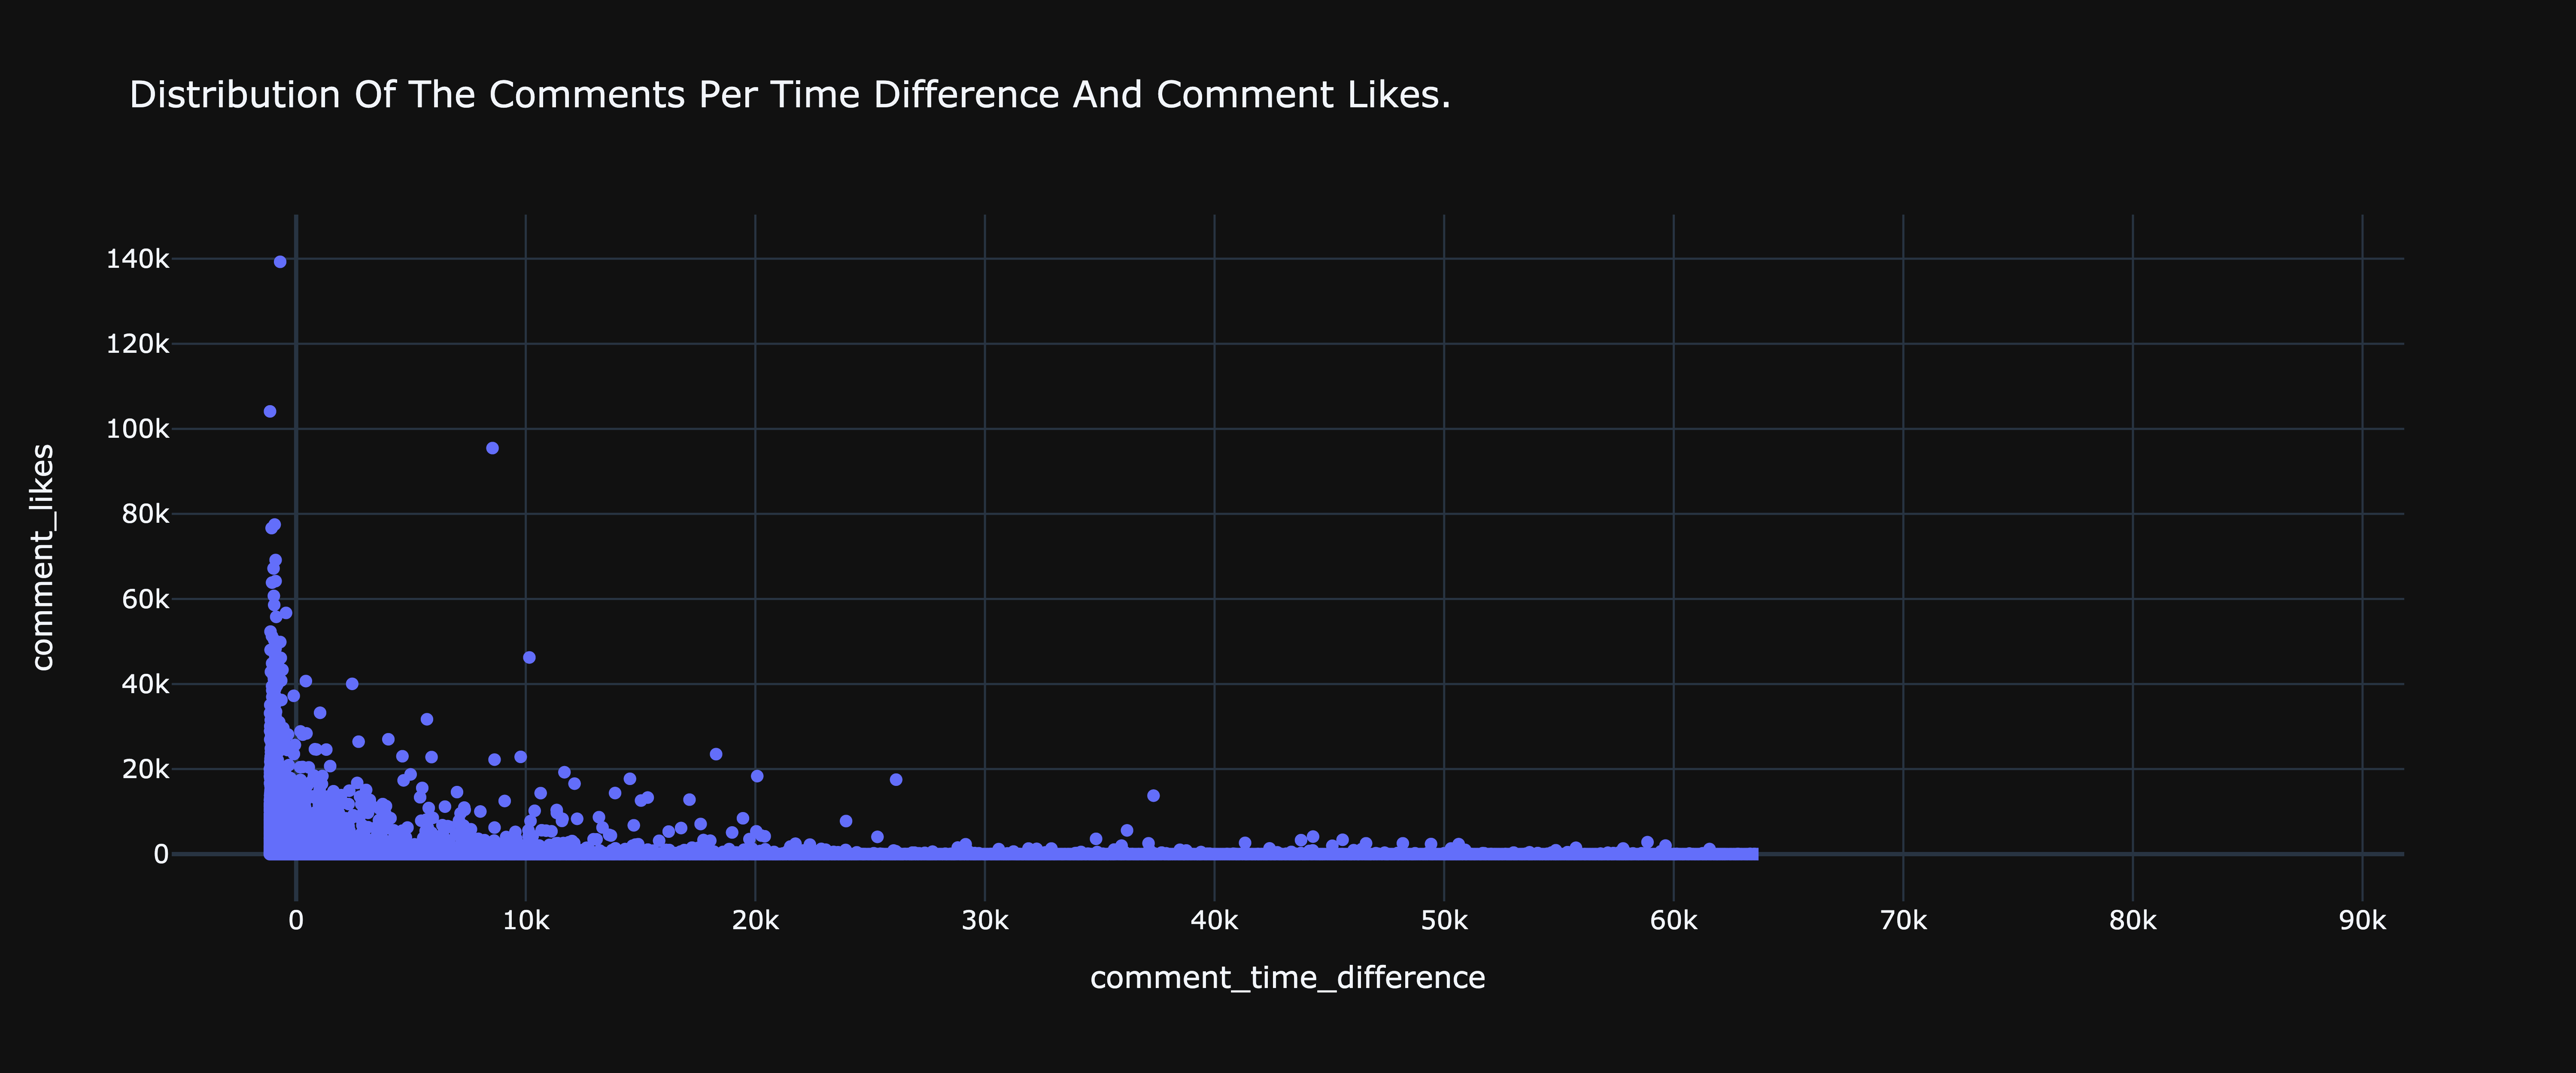

In [23]:
fig = px.scatter(df_comments, 
                 x='comment_time_difference', 
                 y='comment_likes', 
                 title = 'Distribution of the comments per time difference and comment likes.<br><sub>Separated by verified user type')


# Export
file_name = 'Time difference vs comment likes - Dual scatter verified users'
sv.save_plotly_fig(fig, 'image')

There is a general trend, the more time after the post is posted you comment, the less likes you will have. This is because there are already a bunch of poeple that have seen the post before the late comment so less potential like count. Except in rare situations, this is always the case for non verified users, they always have low likes if they don't comment at the beginning. For verified users, it's not the same as they ahave their followers naturally liking their comment or the page owner commenting on its own post. It'll be interesting to see how the distribution changes for bots/legit users.

### 1.6 Comment content

* While scraping the comments, I also collect the button name right under and collected in some comments 'Hide replies' and 'Reply'.
* Many comments have emojis

In [24]:
# Removing hide replies and reply from the comment
df_comments["comment"] = df_comments["comment"].parallel_apply(lambda x: x[:-12] if x[-12:] == "Hide replies" else x)
df_comments["comment"] = df_comments["comment"].parallel_apply(lambda x: x[:-5] if x[-5:] == "Reply" else x)
df_comments["comment"] = df_comments["comment"].parallel_apply(lambda x: x[:x.index('View replies')] if 'View replies' in x else x)

In [25]:
# Adding a column with emoji count of the comments
df_comments["comment_emoji_dict"] = df_comments["comment"].parallel_apply(lambda x: su.count_emoji(x))

# Adding the count of distinct emoji and the count of emojis in total
df_comments["comment_emoji_count"] = df_comments["comment_emoji_dict"].parallel_apply(lambda x: sum(x.values()))
df_comments["comment_emoji_count_distinct"] = df_comments["comment_emoji_dict"].parallel_apply(lambda x: len(x.keys()))

# Removing emoji from comments
df_comments["comment_wo_emoji"] = df_comments["comment"].parallel_apply(lambda x: demoji.replace(x, "").strip())

# # Adding a columns containing all emojis
df_comments["comment_emoji"] = df_comments["comment_emoji_dict"].parallel_apply(lambda x: ''.join(x.keys()))

df_comments.head()

username                                 comment  \
0  carrot-mastodon-of-enthusiasm         BRUH THE BUCKS CANT MISS A SHOT   
1       new-statuesque-binturong  Bobby Portis shooting > Steph shooting   
2           adorable-jade-beluga           Bucks finna have a repeat 🏆 👀   
3      hysterical-glistening-bee            CRAZY EYES GOT MOVES LOL 🤣🤣😭   
4     uber-dragon-of-advertising      Can’t wait for flights reaction 😂😂   

   comment_likes       comment_posted_time  comment_time_difference  \
0           2234 2022-01-14 01:41:33+00:00                       31   
1           3011 2022-01-14 01:42:49+00:00                      107   
2            967 2022-01-14 01:42:37+00:00                       95   
3           1024 2022-01-14 01:45:12+00:00                      250   
4            966 2022-01-14 01:45:27+00:00                      265   

  comment_emoji_dict  comment_emoji_count  comment_emoji_count_distinct  \
0                 {}                    0                             0   
1                 {}                    0                             0   
2   {'👀': 1, '🏆': 1}                    2                             2   
3   {'🤣': 2, '😭': 1}                    3                             2   
4           {'😂': 2}                    2                             1   

                         comment_wo_emoji comment_emoji  
0         BRUH THE BUCKS CANT MISS A SHOT                
1  Bobby Portis shooting > Steph shooting                
2               Bucks finna have a repeat            👀🏆  
3                CRAZY EYES GOT MOVES LOL            🤣😭  
4         Can’t wait for flights reaction             😂

In [26]:
# Top 100 most used emojis
# Add all emojis to same string
all_emojis = ''

for emoji_dict in df_comments['comment_emoji_dict']:
    for key, value in emoji_dict.items():
        for _ in range(value):
            all_emojis += key


# Sort all emojis to 
sorted_emojis = sorted({emoji: all_emojis.count(emoji) for emoji in set(all_emojis)}.items(), key=lambda x: x[1], reverse=True)

# Display top 100 emojis
rows = 5
cols = 20
lst = [['' for _ in range(rows)] for _ in range(cols)]

for index1 in range(cols):
    for index2 in range(rows):
        ind = index2 * cols + index1 + 1
        emoji, count = sorted_emojis[ind - 1]
        white_space = '\n' if index2 == 4 else '\t'
        lst[index1][index2] = f'{ind}: {emoji} - {count} {white_space}'

print('Top 100 most used emojis\n')
print(''.join([''.join(i) for i in lst]))

Top 100 most used emojis

1: 😂 - 23949 	21: 🙏 - 1191 	41: 😈 - 639 	61: ✨ - 318 	81: 🌸 - 221 
2: 🔥 - 16853 	22: 💪 - 1181 	42: 👑 - 637 	62: 🇬 - 315 	82: 😔 - 219 
3: ️ - 10003 	23: 🤦 - 1087 	43: 🤷 - 635 	63: 🔵 - 305 	83: 🇲 - 215 
4: ❤ - 6363 	24: 🇦 - 1067 	44: 💰 - 589 	64: 💚 - 304 	84: 💫 - 214 
5: 😭 - 4331 	25: 🇧 - 1060 	45: 😤 - 560 	65: ⚽ - 289 	85: 😐 - 212 
6: 👏 - 4276 	26: 😮 - 1016 	46: 🥺 - 501 	66: 👊 - 277 	86: 😏 - 208 
7: 😍 - 3955 	27: 🏻 - 928 	47: 👍 - 497 	67: 🌈 - 272 	87: 😒 - 203 
8: 🤣 - 3113 	28: 🖤 - 867 	48: 🏿 - 458 	68: 🙄 - 268 	88: 🏈 - 201 
9: 💜 - 2824 	29: 👀 - 865 	49: ✅ - 451 	69: 🇩 - 268 	89: ❗ - 200 
10: 🙌 - 2349 	30: 🇸 - 854 	50: 🤍 - 437 	70: 😎 - 268 	90: 👌 - 199 
11: ‍ - 2226 	31: 💋 - 819 	51: 🇹 - 425 	71: 🅿 - 266 	91: ⭐ - 197 
12: 💀 - 2175 	32: 🇨 - 789 	52: ⚡ - 422 	72: ☠ - 259 	92: 🍇 - 197 
13: 💙 - 2163 	33: 🤡 - 780 	53: 🤔 - 418 	73: 💸 - 251 	93: 🇿 - 194 
14: 🏾 - 1940 	34: 🏼 - 755 	54: 😅 - 413 	74: 🤩 - 250 	94: 🥱 - 193 
15: 🇷 - 1937 	35: 🇺 - 738 	55: 😩 - 404 	75: 🍀 - 24

### 1.7 Export data

In [27]:
df_comments['comment_emoji_dict'] = df_comments['comment_emoji_dict'].astype(str)
df_comments.drop_duplicates().to_sql('clean_comments', con, if_exists='replace', index=False)

134226

In [28]:
os.system('say "comments done"')

0

## 2. Last 12 posts

This is the table containing all the information about the last 12 posts of the users. 12 is not chosen but the number of posts automatically sent back by Instagram when looking a user profile. Each row is a post of a user. 


### 2.1 Load data and quick expolore

In [29]:
df_last12.head()

username  video_views  \
0     bulky-sepia-bittern          NaN   
1  fluorescent-bulky-newt          NaN   
2  fluorescent-bulky-newt          NaN   
3      real-cautious-wren          NaN   
4      real-cautious-wren       146.00   

                                         display_url  \
0  https://scontent-lga3-1.cdninstagram.com/v/t51...   
1  https://scontent-lga3-2.cdninstagram.com/v/t51...   
2  https://scontent-iad3-1.cdninstagram.com/v/t51...   
3  https://scontent-lga3-2.cdninstagram.com/v/t51...   
4  https://scontent-lga3-2.cdninstagram.com/v/t51...   

                                       thumbnail_src  \
0  https://scontent-lga3-1.cdninstagram.com/v/t51...   
1  https://scontent-lga3-2.cdninstagram.com/v/t51...   
2  https://scontent-iad3-1.cdninstagram.com/v/t51...   
3  https://scontent-lga3-2.cdninstagram.com/v/t51...   
4  https://scontent-lga3-2.cdninstagram.com/v/t51...   

                               accessibility_caption is_video  likes  \
0  Photo by #ReallyMoneyMakin ❤️💰 on January 17, ...        0 161.00   
1  Photo by ᗪ乇丂爪ㄖ几ᗪ 999🅿️ on October 08, 2021. Ma...        0  94.00   
2  Photo by ᗪ乇丂爪ㄖ几ᗪ 999 on October 08, 2021. May ...        0  93.00   
3                                               None        0  16.00   
4                                               None        1  14.00   

   comments        timestamp  
0      2.00 1,610,931,317.00  
1     37.00 1,633,745,048.00  
2     37.00 1,633,745,048.00  
3      0.00 1,639,955,267.00  
4      0.00 1,638,472,080.00

In [30]:
df_last12.describe(include='all')

username   video_views  \
count                 403208     74,681.00   
unique                 40792           NaN   
top     warm-accurate-quokka           NaN   
freq                      36           NaN   
mean                     NaN      8,884.10   
std                      NaN    193,119.85   
min                      NaN          0.00   
25%                      NaN        123.00   
50%                      NaN        396.00   
75%                      NaN      1,576.00   
max                      NaN 29,283,666.00   

                                              display_url  \
count                                              403208   
unique                                             403189   
top     https://scontent-bos3-1.cdninstagram.com/v/t51...   
freq                                                    2   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                            thumbnail_src  \
count                                              403208   
unique                                             403187   
top     https://scontent-bos3-1.cdninstagram.com/v/t51...   
freq                                                    2   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    accessibility_caption is_video  \
count                                              318856   403208   
unique                                             284400        4   
top     Photo by @lilbutchiesoles on October 23, 2021....        0   
freq                                                   24   326964   
mean                                                  NaN      NaN   
std                                                   NaN      NaN   
min                                                   NaN      NaN   
25%                                                   NaN      NaN   
50%                                                   NaN      NaN   
75%                                                   NaN      NaN   
max                                                   NaN      NaN   

              likes   comments        timestamp  
count    403,208.00 403,208.00       403,208.00  
unique          NaN        NaN              NaN  
top             NaN        NaN              NaN  
freq            NaN        NaN              NaN  
mean         448.03      17.37 1,621,740,574.15  
std        6,438.62      76.33    31,509,341.48  
min            0.00       0.00 1,334,434,403.00  
25%           27.00       1.00 1,617,583,546.00  
50%           77.00       4.00 1,634,673,614.50  
75%          197.00      15.00 1,640,530,645.50  
max    2,331,247.00  15,354.00 1,667,448,109.00

In [31]:
df_last12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403208 entries, 0 to 403207
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   username               403208 non-null  object 
 1   video_views            74681 non-null   float64
 2   display_url            403208 non-null  object 
 3   thumbnail_src          403208 non-null  object 
 4   accessibility_caption  318856 non-null  object 
 5   is_video               403208 non-null  object 
 6   likes                  403208 non-null  float64
 7   comments               403208 non-null  float64
 8   timestamp              403208 non-null  float64
dtypes: float64(4), object(5)
memory usage: 27.7+ MB


In [32]:
df_last12.isna().sum()

username                      0
video_views              328527
display_url                   0
thumbnail_src                 0
accessibility_caption     84352
is_video                      0
likes                         0
comments                      0
timestamp                     0
dtype: int64

Couple of insights from that: 
* Missing values in video views but this is likely due to photos posts
* About 75k missing captions and 300k video views. Those are maybe due to posts being photos and just no caption
* Most of the columns have the wrong datatypes (float instead of int, object for date)


### 2.2 Removing irrelevant columns and renaming some

In [33]:
# Renaming some columns
df_last12 = df_last12.rename({"timestamp": "posted_time",
                              'accessibility_caption': 'caption'}, axis=1)

# Removing and reordering columns
df_last12 = df_last12.drop(['display_url', 'thumbnail_src'], axis=1)
df_last12 = df_last12[["username", "likes", "is_video", "video_views", "caption", "comments", "posted_time"]]

df_last12.head()

username  likes is_video  video_views  \
0     bulky-sepia-bittern 161.00        0          NaN   
1  fluorescent-bulky-newt  94.00        0          NaN   
2  fluorescent-bulky-newt  93.00        0          NaN   
3      real-cautious-wren  16.00        0          NaN   
4      real-cautious-wren  14.00        1       146.00   

                                             caption  comments  \
0  Photo by #ReallyMoneyMakin ❤️💰 on January 17, ...      2.00   
1  Photo by ᗪ乇丂爪ㄖ几ᗪ 999🅿️ on October 08, 2021. Ma...     37.00   
2  Photo by ᗪ乇丂爪ㄖ几ᗪ 999 on October 08, 2021. May ...     37.00   
3                                               None      0.00   
4                                               None      0.00   

       posted_time  
0 1,610,931,317.00  
1 1,633,745,048.00  
2 1,633,745,048.00  
3 1,639,955,267.00  
4 1,638,472,080.00

### 2.3 Removing dupes

When collecting the data, some users have been collected multiple times, this step is to remove the duplicates.

In [34]:
df_last12['row_num'] = df_last12.sort_values(['username', 'posted_time', 'video_views', 'likes', 'comments'], ascending=False).groupby(['username', 'posted_time']).cumcount() + 1
df_last12 = df_last12.query('row_num == 1').drop('row_num', axis=1).reset_index(drop=True)

### 2.3 Videos 

Checking for missing values and changing types

In [35]:
# Changing the type of is_video
df_last12['is_video'] = df_last12['is_video'].replace({'0.0': '0', '1.0': '1'}).astype(int)

ratio = df_last12['is_video'].sum() / df_last12.shape[0]
print(f'Ratio to videos for all posts: {round(ratio, 2)}')

Ratio to videos for all posts: 0.19


In [36]:
# Looking at missing values for post being is video and is not
df_last12['video_views'].isna().sum()
for x in (0, 1):
    print(x, df_last12.query(f'is_video == {x}')['video_views'].isna().sum())

0 305257
1 0


In [37]:
# Replacing missing video views by 0
df_last12['video_views'] = df_last12['video_views'].fillna(0).astype(int)

Missing values are only for when the post is a video. Knowing there is the `is_video` flag in another column, I can fill the missing values by 0

In [38]:
# By removing the top 1% of the data, it's easier to see the distribution of the video views
percent99 = df_last12.query('is_video == 1')['video_views'].quantile(0.99)
print(f'{percent99 = :,.0f}')

fig_percent99 = px.histogram(df_last12.query('video_views < @percent99 and is_video == 1'), 
                             x='video_views', 
                             nbins=1000)
                             
fig_percent99.update_layout(xaxis_range=(0, percent99))

percent99 = 115,916


### 2.4 Caption extraction

The caption contains the caption, date, people tagged but I won't do NLP and I have the timestamp so date so I'm only keeping if/how many accounts are tagged

In [39]:
# Counting tagged people and removing the column 
df_last12['tagg_count'] = df_last12['caption'].str.count('@').fillna(0).astype(int)
df_last12.head()

username  likes  is_video  video_views  \
0     bulky-sepia-bittern 161.00         0            0   
1  fluorescent-bulky-newt  94.00         0            0   
2      real-cautious-wren  16.00         0            0   
3      real-cautious-wren  14.00         1          146   
4      real-cautious-wren  16.00         0            0   

                                             caption  comments  \
0  Photo by #ReallyMoneyMakin ❤️💰 on January 17, ...      2.00   
1  Photo by ᗪ乇丂爪ㄖ几ᗪ 999🅿️ on October 08, 2021. Ma...     37.00   
2                                               None      0.00   
3                                               None      0.00   
4  Photo by Cory J Campbell on November 29, 2021....      0.00   

       posted_time  tagg_count  
0 1,610,931,317.00           0  
1 1,633,745,048.00           0  
2 1,639,955,267.00           0  
3 1,638,472,080.00           0  
4 1,638,202,777.00           0

### 2.5 Timestamp & likes CHECK TO BE SURE THAT ALL USERS HAVE MAX 12 POSTS AS THERE ARE DUPES AND USERS WITH 12+ POSTS

Changing then dtype of timestamp and likes to be datetime and likes

In [40]:
df_last12['likes'] = df_last12['likes'].astype(int)
df_last12['posted_time'] = pd.to_datetime(df_last12['posted_time'], unit='s')
df_last12.head()

username  likes  is_video  video_views  \
0     bulky-sepia-bittern    161         0            0   
1  fluorescent-bulky-newt     94         0            0   
2      real-cautious-wren     16         0            0   
3      real-cautious-wren     14         1          146   
4      real-cautious-wren     16         0            0   

                                             caption  comments  \
0  Photo by #ReallyMoneyMakin ❤️💰 on January 17, ...      2.00   
1  Photo by ᗪ乇丂爪ㄖ几ᗪ 999🅿️ on October 08, 2021. Ma...     37.00   
2                                               None      0.00   
3                                               None      0.00   
4  Photo by Cory J Campbell on November 29, 2021....      0.00   

          posted_time  tagg_count  
0 2021-01-18 00:55:17           0  
1 2021-10-09 02:04:08           0  
2 2021-12-19 23:07:47           0  
3 2021-12-02 19:08:00           0  
4 2021-11-29 16:19:37           0

### 2.6 Export table

In [41]:
df_last12.drop_duplicates().to_sql('clean_last12', con, if_exists='replace', index=False)

375178

In [42]:
os.system('say "last 12 done"')

0

##  3. User Profile Data

User profile data is all the information on the user, each row is a single user, not like the precedent table.

### 3.1 Load data and quick expolore

In [43]:
df_users.describe(include='all').round()

biography  blocked_by_viewer  \
count                                               77336          94,848.00   
unique                                              69135                NaN   
top     💗My new profile💗\n💗I want play and dating💗\nI’...                NaN   
freq                                                   87                NaN   
mean                                                  NaN               0.00   
std                                                   NaN               0.00   
min                                                   NaN               0.00   
25%                                                   NaN               0.00   
50%                                                   NaN               0.00   
75%                                                   NaN               0.00   
max                                                   NaN               0.00   

        restricted_by_viewer  country_block       external_url  \
count                 213.00      94,848.00              21997   
unique                   NaN            NaN              18831   
top                      NaN            NaN  http://gmail.com/   
freq                     NaN            NaN                109   
mean                    0.00           0.00                NaN   
std                     0.00           0.00                NaN   
min                     0.00           0.00                NaN   
25%                     0.00           0.00                NaN   
50%                     0.00           0.00                NaN   
75%                     0.00           0.00                NaN   
max                     0.00           0.00                NaN   

                                 external_url_linkshimmed  \
count                                               21997   
unique                                              21997   
top     https://l.instagram.com/?u=http%3A%2F%2Feugyda...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

        edge_followed_by_count                      fbid  followed_by_viewer  \
count                94,848.00                 94,848.00           94,848.00   
unique                     NaN                       NaN                 NaN   
top                        NaN                       NaN                 NaN   
freq                       NaN                       NaN                 NaN   
mean                  3,975.00 17,841,411,838,234,210.00                0.00   
std                 114,362.00         16,061,070,480.00                0.00   
min                       0.00 17,841,400,000,183,024.00                0.00   
25%                     264.00 17,841,401,301,103,416.00                0.00   
50%                     593.00 17,841,404,062,646,388.00                0.00   
75%                   1,232.00 17,841,413,210,262,820.00                0.00   
max              30,442,605.00 17,841,451,735,931,842.00                0.00   

        edge_follow_count  follows_viewer full_name  has_ar_effects  \
count           94,848.00       94,848.00     83642       94,848.00   
unique                NaN             NaN     69540             NaN   
top                   NaN             NaN     Chris             NaN   
freq                  NaN             NaN        73             NaN   
mean               985.00            0.00       NaN            0.00   
std              1,155.00            0.00       NaN            0.00   
min                  0.00            0.00       NaN            0.00   
25%                317.00       

In [44]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94848 entries, 0 to 94847
Data columns (total 97 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   biography                                         77336 non-null  object 
 1   blocked_by_viewer                                 94848 non-null  int64  
 2   restricted_by_viewer                              213 non-null    float64
 3   country_block                                     94848 non-null  int64  
 4   external_url                                      21997 non-null  object 
 5   external_url_linkshimmed                          21997 non-null  object 
 6   edge_followed_by_count                            94848 non-null  int64  
 7   fbid                                              94848 non-null  int64  
 8   followed_by_viewer                                94848 non-null  int64  
 9   edge_follow_count

Many columns are not useful to the rest of the analysis, some other have no meaning so we'll remove them

* Most of the columns have no mising values
* The columns 'is_xxx' and 'xxx_count' have wrong data types, they should be integers
* There are five pronouns columns with all different count of missing values
* The business and professional columns don't have the same count of missing values which is odd as I was imaginating that business attributes are for all busienss account
* The last 9 columns have only two non missing values. the user has 'STATE_CONTROLLED_MEDIA' for transparancy_product
* external_url_linkshimmed: Instagram redirect, useless as eternal_url is already there
* fbid & id: facebook/IG id, not relevant
* profile_pic_url and profile_pic_url_hd: not relevant, photos already downloaded


### 3.2 Renaming and removing columns: 


In [45]:
# Removing constant columns and columns with 100% missing values
for column in df_users.columns:
    if column in ('pronouns_2', 'pronouns_3', 'is_verified'): 
        continue 

    values = df_users[column].unique()
    na = df_users[column].isna().sum()

    # Removing N/As > .9900%
    if na / df_users.shape[0] > .99: 
        df_users = df_users.drop(column, axis=1)
        print(f"NA - {column} removed, missing values: {na} - {na/df_users.shape[0]:.1%}")
        continue

    # Removing constants
    if len(values) == 1:
        df_users = df_users.drop(column, axis=1)
        print(f"C - {column} removed, constant: {values[0]}")

C - blocked_by_viewer removed, constant: 0
NA - restricted_by_viewer removed, missing values: 94635 - 99.8%
C - country_block removed, constant: 0
C - followed_by_viewer removed, constant: 0
C - follows_viewer removed, constant: 0
C - has_channel removed, constant: 0
C - has_blocked_viewer removed, constant: 0
C - has_requested_viewer removed, constant: 0
NA - business_address_json removed, missing values: 94848 - 100.0%
NA - business_email removed, missing values: 94848 - 100.0%
NA - business_phone_number removed, missing values: 94848 - 100.0%
NA - overall_category_name removed, missing values: 94848 - 100.0%
C - edge_mutual_followed_by_count removed, constant: 0
NA - edge_mutual_followed_by_edges removed, missing values: 94848 - 100.0%
C - requested_by_viewer removed, constant: 0
NA - connected_fb_page removed, missing values: 94848 - 100.0%
NA - pronouns removed, missing values: 94848 - 100.0%
NA - bio_links removed, missing values: 94848 - 100.0%
NA - biography_with_entities_raw_t

In [46]:
# Useless columns
cols_to_remove = ['external_url_linkshimmed', 'fbid', 'id', 'profile_pic_url', 'profile_pic_url_hd']
 
for col in cols_to_remove: 
    try:
        df_users = df_users.drop(col, axis=1)
        print(f'{col} - removed')
    except:
        print(col)


# Rename columns 
df_users = df_users.rename({'edge_followed_by_count': 'follower_count',
                            'edge_follow_count': 'follow_count'}, axis=1)

external_url_linkshimmed - removed
fbid - removed
id - removed
profile_pic_url - removed
profile_pic_url_hd - removed


In [47]:
df_users.head(5)

biography  \
0  Always Be Yourself Because an Original is Alwa...   
1  * God\n* Family\n* Redsox \n* Patriots\n* Celt...   
2                 Dm🌍bb \nJeri Racks💰\nScrap Bandz👼🏾   
3                                               None   
4                                               None   

                   external_url  follower_count  follow_count  \
0        http://eugydavies.com/            5853           597   
1                          None              90           119   
2  https://youtu.be/JCHc7sPSCUk            1297           995   
3                          None             198          1936   
4                          None             276          2221   

          full_name  has_ar_effects  has_clips  has_guides  \
0              Eugy               0          0           0   
1      Kyle Bragdon               0          0           0   
2            Elijah               0          0           0   
3  Daniel Contreras               0          0           0   
4               Arf               0          0           0   

   highlight_reel_count  hide_like_and_view_counts  is_business_account  \
0                     0                          0                    0   
1                     0                          0                    0   
2                     7                          0                    0   
3                     0                          0                    0   
4                     0                          0                    0   

   is_professional_account  is_embeds_disabled  is_joined_recently  \
0                        0                   0                   0   
1                        0                   0                   0   
2                        1                   0                   0   
3                        0                   0                   0   
4                        0                   0                   0   

  business_contact_method business_category_name category_enum category_name  \
0                    None                   None          None          None   
1                    None                   None          None          None   
2                    None                   None          None       Athlete   
3                    None                   None          None          None   
4                    None                   None          None          None   

   is_private  is_verified  should_show_category  should_show_public_contacts  \
0           1            0                     0                            0   
1           1            0                     0                            0   
2           0            0                     0                            0   
3           1            0                     0                            0   
4           1            0                     0                            0   

                       username pronouns_0  video_count  post_count  \
0     nondescript-merry-termite         he            0           4   
1        classic-demonic-marten       None            0         149   
2             sincere-silky-fox       None            1           6   
3      new-energetic-junglefowl       None            0         302   
4  heavenly-chamois-of-serenity       None            0           0   

  pronouns_1 pronouns_2 pronouns_3  
0       None       None       None  
1       None       None       None  
2       None       None       None  
3       None       None       None  
4       None       None       None

### 3.x Missing values

Replacing missing values by an empty string

In [48]:
df_users.isna().sum()

biography                      17512
external_url                   72851
follower_count                     0
follow_count                       0
full_name                      11206
has_ar_effects                     0
has_clips                          0
has_guides                         0
highlight_reel_count               0
hide_like_and_view_counts          0
is_business_account                0
is_professional_account            0
is_embeds_disabled                 0
is_joined_recently                 0
business_contact_method        80800
business_category_name         85320
category_enum                  86971
category_name                  68522
is_private                         0
is_verified                        0
should_show_category               0
should_show_public_contacts        0
username                           1
pronouns_0                     91967
video_count                        0
post_count                         0
pronouns_1                     92763
p

In [49]:
df_users['biography'] = df_users['biography'].fillna('')
df_users['full_name'] = df_users['full_name'].fillna('')

### 3.3 External url

Keeping only the domain

In [50]:
# Getting the domain of the url and removing external url
df_users['domain'] = df_users["external_url"].apply(lambda x: urlparse(x).netloc.replace('www.', '') if x != None else x)
df_users['domain'] = df_users["domain"].apply(lambda x: 'netlify.app' if x != None and 'netlify.app' in x else x)
df_users = df_users.drop('external_url', axis=1)

df_users['domain'].value_counts().head(30)

youtu.be                 2348
linktr.ee                2325
youtube.com              1323
linkr.bio                1294
bit.ly                   1172
twitch.tv                 405
open.spotify.com          403
m.youtube.com             402
twitter.com               387
hudl.com                  358
socprofile.com            316
soundcloud.app.goo.gl     308
music.apple.com           287
vm.tiktok.com             248
vsco.co                   244
facebook.com              230
netlify.app               215
soundcloud.com            202
tellonym.me               185
instagram.com             167
gofund.me                 162
cutt.ly                   160
t.me                      138
gmail.com                 117
distrokid.com             103
gofundme.com               87
discord.gg                 85
unitedmasters.com          81
jw.org                     71
wa.me                      66
Name: domain, dtype: int64

### 3.4 Pronouns

Multiple columns are named pronouns but don't have the same number of values in each. The goal is to consolidate the columns into one.

In [51]:
df_users.head(5)

biography  follower_count  \
0  Always Be Yourself Because an Original is Alwa...            5853   
1  * God\n* Family\n* Redsox \n* Patriots\n* Celt...              90   
2                 Dm🌍bb \nJeri Racks💰\nScrap Bandz👼🏾            1297   
3                                                                198   
4                                                                276   

   follow_count         full_name  has_ar_effects  has_clips  has_guides  \
0           597              Eugy               0          0           0   
1           119      Kyle Bragdon               0          0           0   
2           995            Elijah               0          0           0   
3          1936  Daniel Contreras               0          0           0   
4          2221               Arf               0          0           0   

   highlight_reel_count  hide_like_and_view_counts  is_business_account  \
0                     0                          0                    0   
1                     0                          0                    0   
2                     7                          0                    0   
3                     0                          0                    0   
4                     0                          0                    0   

   is_professional_account  is_embeds_disabled  is_joined_recently  \
0                        0                   0                   0   
1                        0                   0                   0   
2                        1                   0                   0   
3                        0                   0                   0   
4                        0                   0                   0   

  business_contact_method business_category_name category_enum category_name  \
0                    None                   None          None          None   
1                    None                   None          None          None   
2                    None                   None          None       Athlete   
3                    None                   None          None          None   
4                    None                   None          None          None   

   is_private  is_verified  should_show_category  should_show_public_contacts  \
0           1            0                     0                            0   
1           1            0                     0                            0   
2           0            0                     0                            0   
3           1            0                     0                            0   
4           1            0                     0                            0   

                       username pronouns_0  video_count  post_count  \
0     nondescript-merry-termite         he            0           4   
1        classic-demonic-marten       None            0         149   
2             sincere-silky-fox       None            1           6   
3      new-energetic-junglefowl       None            0         302   
4  heavenly-chamois-of-serenity       None            0           0   

  pronouns_1 pronouns_2 pronouns_3          domain  
0       None       None       None  eugydavies.com  
1       None       None       None            None  
2       None       None       None        youtu.be  
3       None       None       None            None  
4       None       None       None            None

The pronouns columns is useless as it has no information except missing values and empty strings

In [52]:
pronouns_columns = ['pronouns_0', 'pronouns_1', 'pronouns_2', 'pronouns_3']

# Concating all the columns into one
df_users['pronouns'] = df_users[pronouns_columns].parallel_apply(lambda x: ', '.join(sorted([x[col] for col in pronouns_columns if pd.notna(x[col])])), axis=1)
df_users['pronouns'] = df_users['pronouns'].parallel_apply(lambda x: np.nan if x == '' else x)
df_users['pronouns'].value_counts().head(15)

he, him           1087
him                493
her, she           380
he, him, his       198
he                  62
her, hers, she      51
it                  41
e                   38
them, they          30
hers                29
him, its            29
he, they            25
she                 21
she, they           18
her                 12
Name: pronouns, dtype: int64

In [53]:
# All pronouns distribution
pd.concat([pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(), 
pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(normalize=True).round(2)], axis=1)

pronouns_valcount = pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts().round(2)
pronouns_valcount_normalized = pd.concat([df_users[col] for col in pronouns_columns], axis = 0).value_counts(normalize=True).round(2)

# Removing pronouns columns
df_users = df_users.drop(pronouns_columns, axis=1)

print('Distribution of the pronoumns and the normalized value')
pd.concat([pronouns_valcount, pronouns_valcount_normalized], axis=1)

Distribution of the pronoumns and the normalized value


0    1
him     1851 0.34
he      1424 0.26
she      499 0.09
her      460 0.08
his      222 0.04
they     121 0.02
hers      91 0.02
it        75 0.01
them      60 0.01
e         49 0.01
its       46 0.01
xyr       40 0.01
zir       37 0.01
per       33 0.01
ze        32 0.01
thon      25 0.00
nee       24 0.00
ne        23 0.00
cos       22 0.00
ey        22 0.00
faer      22 0.00
zie       21 0.00
thons     19 0.00
ver       19 0.00
mers      19 0.00
vi        17 0.00
xe        16 0.00
pers      16 0.00
xem       13 0.00
em        13 0.00
co        12 0.00
hir       11 0.00
fae       11 0.00
ve        10 0.00
mer       10 0.00
vis        9 0.00
eir        8 0.00
vir        7 0.00
theirs     7 0.00
nir        6 0.00
ner        4 0.00
nirs       4 0.00
ners       4 0.00

In [54]:
df_users.head(5)

biography  follower_count  \
0  Always Be Yourself Because an Original is Alwa...            5853   
1  * God\n* Family\n* Redsox \n* Patriots\n* Celt...              90   
2                 Dm🌍bb \nJeri Racks💰\nScrap Bandz👼🏾            1297   
3                                                                198   
4                                                                276   

   follow_count         full_name  has_ar_effects  has_clips  has_guides  \
0           597              Eugy               0          0           0   
1           119      Kyle Bragdon               0          0           0   
2           995            Elijah               0          0           0   
3          1936  Daniel Contreras               0          0           0   
4          2221               Arf               0          0           0   

   highlight_reel_count  hide_like_and_view_counts  is_business_account  \
0                     0                          0                    0   
1                     0                          0                    0   
2                     7                          0                    0   
3                     0                          0                    0   
4                     0                          0                    0   

   is_professional_account  is_embeds_disabled  is_joined_recently  \
0                        0                   0                   0   
1                        0                   0                   0   
2                        1                   0                   0   
3                        0                   0                   0   
4                        0                   0                   0   

  business_contact_method business_category_name category_enum category_name  \
0                    None                   None          None          None   
1                    None                   None          None          None   
2                    None                   None          None       Athlete   
3                    None                   None          None          None   
4                    None                   None          None          None   

   is_private  is_verified  should_show_category  should_show_public_contacts  \
0           1            0                     0                            0   
1           1            0                     0                            0   
2           0            0                     0                            0   
3           1            0                     0                            0   
4           1            0                     0                            0   

                       username  video_count  post_count          domain  \
0     nondescript-merry-termite            0           4  eugydavies.com   
1        classic-demonic-marten            0         149            None   
2             sincere-silky-fox            1           6        youtu.be   
3      new-energetic-junglefowl            0         302            None   
4  heavenly-chamois-of-serenity            0           0            None   

  pronouns  
0       he  
1      NaN  
2      NaN  
3      NaN  
4      NaN

### 3.5 Count and binary columns

Many columns are binary, 1 or 0 to express if a user is a business account, is verified, etc and other expressing count as follower count, post counts, etc. All or most of those columns don't have a proper datatype but are objects where they should be integers

In [55]:
# For each binary feature and the ones with count in name, check the value and count missing values after adding to the list
binary_columns = []
for col in df_users: 
    if len(df_users[col].unique()) == 2: 
        binary_columns.append(col)
        print(f'Binary - {col} - {df_users[col].dtype}', list(df_users[col].unique()), df_users[col].isna().sum())


count_columns = []
for col in df_users: 
    if 'count' in col and col not in binary_columns: 
        count_columns.append(col)
        print(f'Count - {col} - {df_users[col].dtype}', col, len(df_users[col].unique()), df_users[col].isna().sum())

Binary - has_ar_effects - int64 [0, 1] 0
Binary - has_clips - int64 [0, 1] 0
Binary - has_guides - int64 [0, 1] 0
Binary - hide_like_and_view_counts - int64 [0, 1] 0
Binary - is_business_account - int64 [0, 1] 0
Binary - is_professional_account - int64 [0, 1] 0
Binary - is_embeds_disabled - int64 [0, 1] 0
Binary - is_joined_recently - int64 [0, 1] 0
Binary - is_private - int64 [1, 0] 0
Binary - should_show_category - int64 [0, 1] 0
Binary - should_show_public_contacts - int64 [0, 1] 0
Count - follower_count - int64 follower_count 9631 0
Count - follow_count - int64 follow_count 5692 0
Count - highlight_reel_count - int64 highlight_reel_count 182 0
Count - video_count - int64 video_count 572 0
Count - post_count - int64 post_count 3738 0


All columns with count in the name have the correct datatype and are clean of missing values. However, the Binary columns don't have the right type.

In [56]:
for col in binary_columns: 
    df_users[col] = df_users[col].astype(int)

In [57]:
df_users.head(5)

biography  follower_count  \
0  Always Be Yourself Because an Original is Alwa...            5853   
1  * God\n* Family\n* Redsox \n* Patriots\n* Celt...              90   
2                 Dm🌍bb \nJeri Racks💰\nScrap Bandz👼🏾            1297   
3                                                                198   
4                                                                276   

   follow_count         full_name  has_ar_effects  has_clips  has_guides  \
0           597              Eugy               0          0           0   
1           119      Kyle Bragdon               0          0           0   
2           995            Elijah               0          0           0   
3          1936  Daniel Contreras               0          0           0   
4          2221               Arf               0          0           0   

   highlight_reel_count  hide_like_and_view_counts  is_business_account  \
0                     0                          0                    0   
1                     0                          0                    0   
2                     7                          0                    0   
3                     0                          0                    0   
4                     0                          0                    0   

   is_professional_account  is_embeds_disabled  is_joined_recently  \
0                        0                   0                   0   
1                        0                   0                   0   
2                        1                   0                   0   
3                        0                   0                   0   
4                        0                   0                   0   

  business_contact_method business_category_name category_enum category_name  \
0                    None                   None          None          None   
1                    None                   None          None          None   
2                    None                   None          None       Athlete   
3                    None                   None          None          None   
4                    None                   None          None          None   

   is_private  is_verified  should_show_category  should_show_public_contacts  \
0           1            0                     0                            0   
1           1            0                     0                            0   
2           0            0                     0                            0   
3           1            0                     0                            0   
4           1            0                     0                            0   

                       username  video_count  post_count          domain  \
0     nondescript-merry-termite            0           4  eugydavies.com   
1        classic-demonic-marten            0         149            None   
2             sincere-silky-fox            1           6        youtu.be   
3      new-energetic-junglefowl            0         302            None   
4  heavenly-chamois-of-serenity            0           0            None   

  pronouns  
0       he  
1      NaN  
2      NaN  
3      NaN  
4      NaN

### 3.6 Business columns 

There are five colmns mentioning characteristics from business accounts: 
* is_business_account
* is_professional_account
* business_contact_method
* business_category_name
* category_enum
* category_name

... and maybe:
* should_show_category
* should_show_public_contacts


In [58]:
business_cols = ['is_business_account', 'is_professional_account', 'category_enum', 'category_name', 'business_category_name', 
                 'business_contact_method', 'should_show_category', 'should_show_public_contacts']

df_users[business_cols].head(20)

is_business_account  is_professional_account  category_enum  \
0                     0                        0           None   
1                     0                        0           None   
2                     0                        1           None   
3                     0                        0           None   
4                     0                        0           None   
5                     0                        0           None   
6                     0                        0           None   
7                     0                        0           None   
8                     0                        1           None   
9                     0                        1           None   
10                    1                        1           None   
11                    0                        1           None   
12                    0                        0           None   
13                    0                        0           None   
14                    0                        0           None   
15                    0                        0           None   
16                    1                        1        ATHLETE   
17                    0                        0           None   
18                    1                        1  PERSONAL_BLOG   
19                    0                        0           None   

         category_name  business_category_name business_contact_method  \
0                 None                    None                    None   
1                 None                    None                    None   
2              Athlete                    None                    None   
3                 None                    None                    None   
4                 None                    None                    None   
5                 None                    None                    None   
6                 None                    None                    None   
7                 None                    None                    None   
8             Musician                    None                    None   
9              Athlete                    None                    None   
10           Education   Professional Services                 UNKNOWN   
11  Dance & Night Club                    None                    None   
12                None                    None                    None   
13                None                    None                    None   
14                None                    None                    None   
15                None                    None                 UNKNOWN   
16             Athlete  Creators & Celebrities                    None   
17                None                    None                    None   
18       Personal blog  Creators & Celebrities                    None   
19                None                    None                    None   

    should_show_category  should_show_public_contacts  
0                      0                            0  
1                      0                            0  
2                      0                            0  
3                      0                            0  
4                      0                            0  
5                      0                            0  
6                      0                            0  
7                      0                            0  
8                      1                            0  
9                      1                            0  
10                     0                            1  
11                     1                            0  
12                     0                            0  
13                     0                            0  
14                     0                            0  
15                     0                            0  
16                     1                            0  
17                     0         

The missing values are not consistent but I don't think (will still have to check) that the bots are business/professional accounts so those columns don't matter a lot, I can leave the missing values

### 3.7 Biography

In [59]:
# Adding a column with emoji count of the biographys
df_users["biography_emoji_dict"] = df_users["biography"].parallel_apply(lambda x: su.count_emoji(x))

# Adding the count of distinct emoji and the count of emojis in total
df_users["biography_emoji_count"] = df_users["biography_emoji_dict"].parallel_apply(lambda x: sum(x.values()))
df_users["biography_emoji_count_distinct"] = df_users["biography_emoji_dict"].parallel_apply(lambda x: len(x.keys()))

# Removing emoji from biographys
df_users["biography_wo_emoji"] = df_users["biography"].parallel_apply(lambda x: demoji.replace(x, "").strip())

# # Adding a columns containing all emojis
df_users["biography_emoji"] = df_users["biography_emoji_dict"].parallel_apply(lambda x: ''.join(x.keys()))

df_users.head()

biography  follower_count  \
0  Always Be Yourself Because an Original is Alwa...            5853   
1  * God\n* Family\n* Redsox \n* Patriots\n* Celt...              90   
2                 Dm🌍bb \nJeri Racks💰\nScrap Bandz👼🏾            1297   
3                                                                198   
4                                                                276   

   follow_count         full_name  has_ar_effects  has_clips  has_guides  \
0           597              Eugy               0          0           0   
1           119      Kyle Bragdon               0          0           0   
2           995            Elijah               0          0           0   
3          1936  Daniel Contreras               0          0           0   
4          2221               Arf               0          0           0   

   highlight_reel_count  hide_like_and_view_counts  is_business_account  \
0                     0                          0                    0   
1                     0                          0                    0   
2                     7                          0                    0   
3                     0                          0                    0   
4                     0                          0                    0   

   is_professional_account  is_embeds_disabled  is_joined_recently  \
0                        0                   0                   0   
1                        0                   0                   0   
2                        1                   0                   0   
3                        0                   0                   0   
4                        0                   0                   0   

  business_contact_method business_category_name category_enum category_name  \
0                    None                   None          None          None   
1                    None                   None          None          None   
2                    None                   None          None       Athlete   
3                    None                   None          None          None   
4                    None                   None          None          None   

   is_private  is_verified  should_show_category  should_show_public_contacts  \
0           1            0                     0                            0   
1           1            0                     0                            0   
2           0            0                     0                            0   
3           1            0                     0                            0   
4           1            0                     0                            0   

                       username  video_count  post_count          domain  \
0     nondescript-merry-termite            0           4  eugydavies.com   
1        classic-demonic-marten            0         149            None   
2             sincere-silky-fox            1           6        youtu.be   
3      new-energetic-junglefowl            0         302            None   
4  heavenly-chamois-of-serenity            0           0            None   

  pronouns       biography_emoji_dict  biography_emoji_count  \
0       he                   {'♈': 1}                      1   
1      NaN                         {}                      0   
2      NaN  {'💰': 1, '🌍': 1, '👼🏾': 1}                      3   
3      NaN                         {}                      0   
4      NaN                         {}                      0   

   biography_emoji_count_distinct  \
0                               1   
1                               0   
2                               3   
3                               0   
4                               0   

                                  biography_wo_emoji biography_emoji  
0  Always Be Yourself Because an Original is Alwa...               ♈  
1  * God\n* Family\n* Redsox \n* Patriots\n* Celt...                  
2                     Dmbb \nJeri R

### 3.7 Duplicates

Some users have been collected multiple times, so I need to remove the duplicates. knowing a bot can with time, become private or delete its link, i'll order the data ascending and keep the last value as it's the one with less followers/follows

In [60]:
df_users = df_users.sort_values(['follow_count', 'follower_count']).drop_duplicates(subset='username', keep='last')

### 3.7 Export data

In [61]:
df_users['biography_emoji_dict'] = df_users['biography_emoji_dict'].astype(str)
df_users.to_sql('clean_users', con, if_exists='replace', index=False)

86304

In [62]:
os.system('say "ALL DONE"')

0

## 4.0 Merge into one table

Joining all table into a single one.

In [63]:
# Formatting one username per row
query = '''
with cl12 as (
select 
    username 
    -- , sum(likes) as posts_sum_likes
    -- , sum(is_video) as posts_sum_is_video
    -- , sum(video_views) as posts_sum_video_views
    -- , sum(comments) as posts_sum_comments
    -- , sum(posted_time) as posts_sum_posted_time
    -- , sum(tagg_count) as posts_sum_tagg_count

    -- , avg(likes) as posts_avg_likes
    -- , avg(is_video) as posts_avg_is_video
    -- , avg(video_views) as posts_avg_video_views
    -- , avg(comments) as posts_avg_comments
    -- , avg(posted_time) as posts_avg_posted_time
    -- , avg(tagg_count) as posts_avg_tagg_count

    -- , min(likes) as posts_min_likes
    -- , min(is_video) as posts_min_is_video
    -- , min(video_views) as posts_min_video_views
    -- , min(comments) as posts_min_comments
    -- , min(posted_time) as posts_min_posted_time
    -- , min(tagg_count) as posts_min_tagg_count

    -- , max(likes) as posts_max_likes
    -- , max(is_video) as posts_max_is_video
    -- , max(video_views) as posts_max_video_views
    -- , max(comments) as posts_max_comments
    -- , max(posted_time) as posts_max_posted_time
    -- , max(tagg_count) as posts_max_tagg_count

    , group_concat(likes) as posts_concat_likes
    , group_concat(is_video) as posts_concat_is_video
    , group_concat(video_views) as posts_concat_video_views
    , group_concat(comments) as posts_concat_comments
    , group_concat(posted_time) as posts_concat_posted_time
    , group_concat(caption) as posts_concat_caption
    
from clean_last12
group by 1
)


select 
    username
    , biography
    , biography_wo_emoji
    , biography_emoji
    , biography_emoji_count
    , biography_emoji_count_distinct

    , follow_count
    , follower_count
    , pronouns
    , domain
    
    , comment
    , comment_wo_emoji
    , comment_emoji
    , comment_emoji_count
    , comment_emoji_count_distinct
    , comment_time_difference
    , comment_likes 


    , post_count
    , video_count
    , highlight_reel_count
    , hide_like_and_view_counts
    , has_guides
    , has_clips
    , is_private
    , is_embeds_disabled
    , is_joined_recently

    , is_professional_account
    , is_business_account
    , business_contact_method
    , business_category_name
    , category_name
    , category_enum
    , should_show_category
    , should_show_public_contacts

    -- , CAST((julianday(cl.posts_max_posted_time) - julianday(cl.posts_min_posted_time))*24*3600 AS real) as posts_minutes_diff
    -- , cl.posts_sum_likes
    -- , cl.posts_sum_is_video
    -- , cl.posts_sum_video_views
    -- , cl.posts_sum_comments
    -- , cl.posts_sum_posted_time
    -- , cl.posts_sum_tagg_count
    -- , cl.posts_avg_likes
    -- , cl.posts_avg_is_video
    -- , cl.posts_avg_video_views
    -- , cl.posts_avg_comments
    -- , cl.posts_avg_posted_time
    -- , cl.posts_avg_tagg_count
    -- , cl.posts_min_likes
    -- , cl.posts_min_is_video
    -- , cl.posts_min_video_views
    -- , cl.posts_min_comments
    -- , cl.posts_min_posted_time
    -- , cl.posts_min_tagg_count
    -- , cl.posts_max_likes
    -- , cl.posts_max_is_video
    -- , cl.posts_max_video_views
    -- , cl.posts_max_comments
    -- , cl.posts_max_posted_time
    -- , cl.posts_max_tagg_count
    -- , cl.posts_concat_likes
    -- , cl.posts_concat_is_video
    -- , cl.posts_concat_video_views
    -- , cl.posts_concat_comments
    -- , cl.posts_concat_posted_time
    -- , cl.posts_concat_tagg_count

    , cl.posts_concat_likes
    , cl.posts_concat_is_video
    , cl.posts_concat_video_views
    , cl.posts_concat_comments
    , cl.posts_concat_posted_time
    , cl.posts_concat_caption


from clean_comments
left join cl12 cl using(username)
left join clean_users using(username)
'''



df_all_data = pd.read_sql_query(query, con)
df_all_data.to_sql('clean_all_data', con, if_exists='replace', index=False)
# pd.read_sql_query(query, con)

134226

In [64]:
asdf

NameError: name 'asdf' is not defined

### Missing values for follow count (Verified in their name)

In [ ]:
df_username_mapping = pd.read_sql_query('select distinct * from username_mapping order by username', con)
dict(zip(df_username_mapping['username'], df_username_mapping['cooler_name']))
username = pd.read_sql_query('select distinct * from new_clean_comments_users_last12 order by username', con).query('follow_count.isna()')['username'].drop_duplicates()
username.map(dict(zip(df_username_mapping['cooler_name'], df_username_mapping['username']))).str.replace('Verified', '')